In [ ]:
!python --version

Python 3.8.10


In [ ]:
import pandas as pd
from google.colab import drive
import io
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix

In [ ]:
# TPU Acceleration
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

AUTO = tf.data.experimental.AUTOTUNE

# **CLEAN DATA**  ⚡💯⚡


In [ ]:
# Mount drive in order to get CSV file from Drive folder
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [ ]:
import csv 

# Raw metabolite data file
met = pd.read_csv("/content/drive/My Drive/AI_Dyslexia_Diagnostics/raw_data.csv", index_col=0)
print(met.shape)
met = met.dropna(thresh=21, axis=1)
#print(met.index)

X_met = met.iloc[:, 1:]
y_met = met.iloc[:, 0]
print(X_met, y_met)
#print(y_met[y_met == 1].shape)
print(X_met.shape)
col = [col.rsplit(' ', 1)[0] for col in X_met.columns]
print(col)

with open("Met_col.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(col)

# Inpute mean value of column to all NAN values in a column
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_met = imp.fit_transform(X_met)

for var in np.isnan(X_met):
  if var is False: print("false!")

scaler = MinMaxScaler()
scaler.fit(X_met)
X_met = scaler.transform(X_met)

X_train_M, X_test_M, y_train_M, y_test_M = train_test_split(X_met, y_met, test_size=.2, stratify=y_met, random_state=1)

print(X_test_M)
#met.sort_values(by='Label', ascending=True, inplace=True)
#met['Genetic Label'] = 
#print(met['Label'])

(26, 296)
           Phenylbutazone Results  3-hydroxykynurenine Results  dTMP Results  \
Sample ID                                                                      
P084                   324.745792                  7613.303600   1093.918887   
P074                   182.193872                  3856.738298   2117.957173   
P134                    49.808412                  9987.522161    582.683646   
P124                    39.505165                  5252.921115    781.067978   
P049-1                 323.413502                 15536.620100   1312.065327   
P044-1                 139.161686                  6952.299716    822.034807   
P006                   117.288227                  5187.980818    699.544630   
P024                    22.884669                  7543.308604   2033.710092   
P054-2                  59.212101                 17143.030090   3199.968076   
P078                    78.433882                  9429.483591   1175.394792   
P059                   783.104

In [ ]:
final = pd.read_csv("/content/drive/My Drive/AI_Dyslexia_Diagnostics/Genomic_final_data.csv", index_col=0)
#print(final.shape)
print(final.head(5))
final = final[final.Affected != 0]   ### lose some
final_index = final.index
for var in np.isnan(final):
  if var is False: print("false!")

#print(final.index)

X_gen = final.iloc[:,:-1]
y_gen = final.iloc[:,-1:]
#print(X_gen, y_gen)

print(X_gen.columns)
with open("Exome_col.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(X_gen.columns)
    
#print (y_gen[y_gen.Affected ==2].shape)
print (X_gen.shape)
# 80/20 train/test split
X_train_G, X_test_G, y_train_G, y_test_G = train_test_split(X_gen, y_gen, test_size=.2, random_state=1)
#print(X_test_G, y_test_G)

        rs2275827  rs10492942  rs199666818  rs372895950  rs941495  rs74922245  \
326850          2           2            1            1         2           0   
326851          0           0            2            2         2           0   
326853          0           0            2            2         2           0   
326854          0           0            2            2         1           0   
326868          0           0            2            2         2           0   

        rs76102053  rs2280437  rs4660672  rs3014245  ...  rs4830483  \
326850           0          1          2          2  ...          2   
326851           0          2          0          2  ...          2   
326853           0          0          2          1  ...          2   
326854           0          0          2          2  ...          1   
326868           0          1          2          1  ...          0   

        rs17274127  rs5928617  rs5915179  rs2227090  rs4252206  rs12097  \
326850     

In [ ]:
# GnomAD Batch Query
import requests
import pprint
prettyprint = pprint.PrettyPrinter(indent=2).pprint

def fetch(jsondata, url="https://gnomad.broadinstitute.org/api"):
    # The server gives a generic error message if the content type isn't
    # explicitly set
    headers = {"Content-Type": "application/json"}
    response = requests.post(url, json=jsondata, headers=headers)
    json = response.json()
    if "errors" in json:
        raise Exception(str(json["errors"]))
    return json

def get_variant_list(gene_id, dataset="gnomad_r2_1"):
    # Note that this is GraphQL, not JSON.
    fmt_graphql = """
    {
        gene(gene_id: "%s", reference_genome: GRCh38) {
          variants(dataset: %s) {
            consequence
            pos
            rsid
            variant_id: variantId
          }
        }
      }
    """
    # This part will be JSON encoded, but with the GraphQL part left as a
    # glob of text.
    req_variantlist = {
        "query": fmt_graphql % (gene_id, dataset),
        "variables": {}
        }
    response = fetch(req_variantlist)
    return response["data"]["gene"]["variants"]

prettyprint(get_variant_list(X_gen.columns[3])) 

Exception: ignored

In [ ]:
# Raw phenotype data file

phen = pd.read_csv("/content/drive/My Drive/AI_Dyslexia_Diagnostics/BrainGeneticsPhenotypes_3.csv", engine='python')
phen = phen.replace('\.+', np.nan, regex=True)
#print(phen.shape)
# While looking at columns (keep threshold of 61 columns * 0.8 = 49 columns that have to be non-null).  This procedure will yield a matrix that is 61 rows by 76 columns.  Axis 1 will act on all the COLUMNS in each ROW
phen = phen.dropna(thresh=49, axis=1)

# rows (keep threshold of 76 columns *.8 = 61 rows that have to be non-null).  This procedure will yield a matrix that is (58, 73).  Axis 0 will act on all the ROWS in each COLUMN
phen = phen.dropna(thresh= 61, axis=0)

print(phen.columns)
phen = phen.drop(['CELF4off_rs', 'RIAS_GWH_RS', 'RIAS_VRZ_RS', 'RIAS_OIO_RS', 'RIAS_WHM_RS', 'WIDRSofficial', 
                  'papapa_dur', 'tatata_dur', 'kakaka_dur', 'patepate_dur', 'RAN_OBJ_RS', 'pataka_dur',
                  'RAN_COL_RS', 'RAN_NUM_RS', 'RAN_LET_RS', 'RAS_LN_RS', 'RAS_LNC_RS', 'taketake_dur', 'WATTRSofficial',
                  'TOWRE_SWE_final_RS', 'TOWRE_PDE_final_RS', 'WIAT_Spell_RS', 'RIAS_sum', 'RIAS_NIXsum'], axis=1)
print(phen.iloc[:, 5:].columns)
# Get all columns starting from "Age:years"
# Also, inpute values to NULL values
X_p = phen.iloc[:, 5:]
X_p.columns = ['Age', 'CELF4off Score', 'RIAS GWH Score', 'RIAS VRZ Score', 'RIAS VIX Score', 'RIAS OIO', 'RIAS WHM', 'RIAS NIX', 'papapa Score', 'tatata',
       'kakaka', 'pate', 'take', 'pataka_z', 'papapa_pataka_ratio', 'tatata_pataka_ratio', 'kakaka_pataka_ratio', 'papa_pate_ratio',
       'papazminuspataz', 'papazminuspatakaz', 'tataz-pataz', 'tataz-patakaz', 'kakaz-takaz', 'kakaz-patakaz', 'zdiffaverage', 'patezminuspatakaz',
       'DDK Monosyll. Z', 'DDK Multisyll. Z', 'DDK Monos. - Multis. Z', 'RAN OBJ Score', 'RAN COL Score', 'RAN NUM Score', 'RAN LET', 'RAS LN',
       'RAS LNC', 'RANRAS b/d sub', 'RANRAS q/p sub', 'SumVisErr', 'WID Score', 'WID_z', 'WATT zScore', 'WATT Score',
       'TOWRE_SWE_ final_SS', 'SWEz', 'TOWRE_PDE_final_SS', 'PDEz', 'WIAT Spell Score']


imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_p = imp.fit_transform(X_p)
y_p = phen.iloc[:, 3]

#print(phen.columns)
with open("clin_col.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(phen.iloc[:, 5:].columns)

scaler.fit(X_p)
X_p = scaler.transform(X_p)

#print(y_p[y_p == 2].shape)
#print(X_p, y_p)

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p, y_p, test_size=.2, random_state=1)

print(X_train_p.shape)
#print(type(phen['Aff., Unaff.'][0]))

# phen['Ever Affected'], phen['Aff., Unaff.']

Index(['FAMID', 'SUBID', 'SEX', 'Ever Affected', 'Aff., Unaff.', 'Age:years',
       'CELF4off_rs', 'CELF4off_SS', 'RIAS_GWH_RS', 'RIAS_GWH_SS',
       'RIAS_VRZ_RS', 'RIAS_VRZ_SS', 'RIAS_sum', 'RIAS_VIX_ss', 'RIAS_OIO_RS',
       'RIAS_OIO_SS', 'RIAS_WHM_RS', 'RIAS_WHM_SS', 'RIAS_NIXsum',
       'RIAS_NIX_ss', 'papapa_dur', 'papapa_z', 'tatata_dur', 'tatata_z',
       'kakaka_dur', 'kakaka_z', 'patepate_dur', 'pate_z', 'taketake_dur',
       'take_z', 'pataka_dur', 'pataka_z', 'papapa_pataka_ratio',
       'tatata_pataka_ratio', 'kakaka_pataka_ratio', 'papa_pate_ratio',
       'papazminuspataz', 'papazminuspatakaz', 'tataz-pataz', 'tataz-patakaz',
       'kakaz-takaz', 'kakaz-patakaz', 'zdiffaverage', 'patezminuspatakaz',
       'DDK Monosyll. Z', 'DDK Multisyll. Z', 'DDK Monos. - Multis. Z',
       'RAN_OBJ_RS', 'RAN_OBJ_SS', 'RAN_COL_RS', 'RAN_COL_SS', 'RAN_NUM_RS',
       'RAN_NUM_SS', 'RAN_LET_RS', 'RAN_LET_SS', 'RAS_LN_RS', 'RAS_LN_SS',
       'RAS_LNC_RS', 'RAS_LNC_SS', 'RANRAS 

In [ ]:
### Data level

genLabel = [310383, 310382, 310380, 310381, 310357, 310358, 310359, 310391, 310388, 
            310374, 310376, 310377, 310375, 310386, 310373, 310371, 310370, 310362, 
            310364, 310363, 310365, 310366, 310367, 310368]

metLabel = ['P001', 'P005' ,'P011', "P016", "P024", "P029", "P034", "P044-1", "P049-1",
            "P054", "P059" ,"P064", "P069", "P078", "P084", "P090", "P093", "P099", "P104", 
            "P109", "P119", "P124", "P129", "P134"]

combo = pd.DataFrame(genLabel, metLabel)
combo['genL'] = genLabel
combo['metL'] = metLabel
#print(combo.head(1))
#print(final.columns)
#print(met.columns)

combo = pd.merge(combo, final, left_on=['genL'], right_index=True).drop('Affected', axis=1).drop('genL', axis=1)
combo = pd.merge(combo, met, left_on=['metL'], right_index=True).drop('metL', axis=1)
combo2 = combo.loc[:,combo.columns != 'Label']
#print(combo.columns.get_loc('Label'))
#combo.to_csv('/content/drive/My Drive/AI_Dyslexia_Diagnostics/combo.csv')


X_combo = combo.loc[:,:]
X_combo = X_combo.loc[:,X_combo.columns != 'Label']

y_combo = combo.iloc[:, 332]
print(X_combo.shape)
#print(pd.isnull(X_combo))

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_combo = imp.fit_transform(X_combo)

#print(pd.isnull(X_combo))

# 80/20 t&v/test split
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_combo, y_combo, test_size=.2, stratify=y_combo, random_state=39)

print(y_train_C)

(19, 600)
P129      2
P049-1    2
P134      2
P084      1
P069      1
P124      2
P093      2
P011      1
P064      2
P024      2
P104      2
P016      2
P078      2
P034      2
P109      2
Name: Label, dtype: int64


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
### SMOTE ###
##########################################################################################

smote = SMOTE(sampling_strategy='minority', random_state=18, k_neighbors=3)
#smenn = SMOTEENN(sampling_strategy='minority', random_state=18, n_neighbor = 3)

# Metabalomic
X_met_sm, y_met_sm = smote.fit_resample(X_met, y_met)
X_train_M_sm, X_test_M_sm, y_train_M_sm, y_test_M_sm = train_test_split(X_met_sm, y_met_sm, test_size=.2, stratify=y_met_sm)

# Genomic
X_gen_sm, y_gen_sm = smote.fit_resample(X_gen, y_gen)
X_train_G_sm, X_test_G_sm, y_train_G_sm, y_test_G_sm = train_test_split(X_gen_sm, y_gen_sm, test_size=.2, stratify=y_gen_sm)

# Combo
X_combo_sm, y_combo_sm = smote.fit_resample(X_combo, y_combo)
print(len(y_combo))
print('-------')
print(len(y_combo_sm))
X_train_C_sm, X_test_C_sm, y_train_C_sm, y_test_C_sm = train_test_split(X_combo_sm, y_combo_sm, test_size=.22, stratify=y_combo_sm, random_state=333)
print('-------\n', y_test_C_sm)

19
-------
30
-------
 12    1
27    1
16    2
13    2
28    1
9     2
29    1
Name: Label, dtype: int64


In [ ]:
# Scoring metrics

from imblearn.metrics import sensitivity_score, specificity_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, average_precision_score
from sklearn import metrics
import matplotlib.pyplot as plt

scoringa = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
           'roc_auc' : make_scorer(roc_auc_score),
           'precision-recall' : make_scorer(average_precision_score),
           'mcc' : make_scorer(matthews_corrcoef),
           'kappa' : make_scorer(cohen_kappa_score),
           'sensitivity' : make_scorer(sensitivity_score),
           'specificity' : make_scorer(specificity_score)}
           
cv = RepeatedKFold(n_splits=10, n_repeats=1)

metric_used = 'f1_score'

In [ ]:
# Testing functions

def test_metrics(y_true, y_pred):
    return np.array(["acc: %.4f" % accuracy_score(y_true, y_pred), "percision: %.4f" % precision_score(y_true, y_pred), "recall: %.4f" % recall_score(y_true, y_pred), 
                    "F1: %.4f" % f1_score(y_true, y_pred), ": %.4f" % roc_auc_score(y_true, y_pred), "%.4f" % average_precision_score(y_true, y_pred),
                    "%.4f" % matthews_corrcoef(y_true, y_pred), "%.4f" % cohen_kappa_score(y_true, y_pred), "%.4f" % sensitivity_score(y_true, y_pred),
                    "%.4f" % specificity_score(y_true, y_pred)])
def train_metrics(clf):
    index = clf.cv_results_['params'].index(clf.best_params_)
    return np.array([" %.4f" % (clf.cv_results_['mean_train_accuracy'])[index], "Percision: %.4f" % (clf.cv_results_['mean_train_precision'])[index], 
                     "%.4f" % (clf.cv_results_['mean_train_recall'])[index], "%.4f" % (clf.cv_results_['mean_train_f1_score'])[index],
                     "%.4f" % (clf.cv_results_["mean_train_roc_auc"])[index], "%.4f" % (clf.cv_results_['mean_train_precision-recall'])[index],
                     "%.4f" % (clf.cv_results_['mean_train_mcc'])[index], "%.4f" % (clf.cv_results_['mean_train_kappa'])[index],
                     "%.4f" % (clf.cv_results_['mean_train_sensitivity'])[index], "%.4f" % (clf.cv_results_['mean_train_specificity'])[index], clf.best_params_])
    

# **DATA-FUSION**  ⚡💯⚡


In [ ]:
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV


nn_pipe = Pipeline(steps=[('mlp', MLPClassifier())])
param_grid2 = {'mlp__hidden_layer_sizes': [(300, 100, 10), (25, 10, 5), (10, 5, 5, 10)]}

mlp = GridSearchCV(nn_pipe, param_grid2, cv=cv, scoring=scoringa, refit=metric_used, return_train_score=True, verbose=3)
mlp_C_smote_model = mlp.fit(X_train_C_sm, y_train_C_sm)

print("Best estimator found by grid search:")
print("----------------------------------------")
print("----------------------------------------")
print("----------------------------------------")
print(mlp_C_smote_model.best_estimator_)
# RESULT: Pipeline(steps=[('mlp', MLPClassifier(hidden_layer_sizes=(10, 10, 10)))])

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 1/10] END mlp__hidden_layer_sizes=(300, 100, 10); accuracy: (train=0.950, test=0.333) f1_score: (train=0.952, test=0.500) kappa: (train=0.900, test=0.000) mcc: (train=0.905, test=0.000) precision: (train=0.909, test=0.333) precision-recall: (train=0.500, test=0.333) recall: (train=1.000, test=1.000) roc_auc: (train=0.950, test=0.500) sensitivity: (train=1.000, test=1.000) specificity: (train=0.900, test=0.000) total time=   0.3s
[CV 2/10] END mlp__hidden_layer_sizes=(300, 100, 10); accuracy: (train=0.500, test=nan) f1_score: (train=0.615, test=nan) kappa: (train=0.138, test=nan) mcc: (train=0.272, test=nan) precision: (train=0.444, test=nan) precision-recall: (train=0.400, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=0.583, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=0.167, test=nan) total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py", line 572, in roc_auc_score
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_base.py", line 75, in _average_binary_score
    return binary_metric(y_tr

[CV 3/10] END mlp__hidden_layer_sizes=(300, 100, 10); accuracy: (train=0.950, test=1.000) f1_score: (train=0.947, test=1.000) kappa: (train=0.900, test=1.000) mcc: (train=0.905, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.459, test=0.333) recall: (train=0.900, test=1.000) roc_auc: (train=0.950, test=1.000) sensitivity: (train=0.900, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.3s
[CV 4/10] END mlp__hidden_layer_sizes=(300, 100, 10); accuracy: (train=0.905, test=0.000) f1_score: (train=0.909, test=0.000) kappa: (train=0.811, test=-1.000) mcc: (train=0.826, test=-1.000) precision: (train=0.833, test=0.000) precision-recall: (train=0.476, test=1.000) recall: (train=1.000, test=0.000) roc_auc: (train=0.909, test=0.000) sensitivity: (train=1.000, test=0.000) specificity: (train=0.818, test=0.000) total time=   0.2s
[CV 5/10] END mlp__hidden_layer_sizes=(300, 100, 10); accuracy: (train=0.952, test=0.000) f1_score: (train=0.947, test=0.000

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. Th

[CV 8/10] END mlp__hidden_layer_sizes=(300, 100, 10); accuracy: (train=0.905, test=nan) f1_score: (train=0.917, test=nan) kappa: (train=0.807, test=nan) mcc: (train=0.823, test=nan) precision: (train=0.846, test=nan) precision-recall: (train=0.524, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=0.900, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=0.800, test=nan) total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py", line 572, in roc_auc_score
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_base.py", line 75, in _average_binary_score
    return binary_metric(y_tr

[CV 9/10] END mlp__hidden_layer_sizes=(300, 100, 10); accuracy: (train=0.952, test=nan) f1_score: (train=0.941, test=nan) kappa: (train=0.901, test=nan) mcc: (train=0.906, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=0.889, test=nan) roc_auc: (train=0.944, test=nan) sensitivity: (train=0.889, test=nan) specificity: (train=1.000, test=nan) total time=   0.3s
[CV 10/10] END mlp__hidden_layer_sizes=(300, 100, 10); accuracy: (train=0.571, test=0.500) f1_score: (train=0.690, test=0.667) kappa: (train=0.175, test=0.000) mcc: (train=0.309, test=0.000) precision: (train=0.526, test=0.500) precision-recall: (train=0.476, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=0.591, test=0.500) sensitivity: (train=1.000, test=1.000) specificity: (train=0.182, test=0.000) total time=   0.3s
[CV 1/10] END mlp__hidden_layer_sizes=(25, 10, 5); accuracy: (train=0.750, test=0.667) f1_score: (train=0.783, test=0.667) kappa: (train=0.500, t

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV 4/10] END mlp__hidden_layer_sizes=(25, 10, 5); accuracy: (train=0.524, test=0.500) f1_score: (train=0.000, test=0.000) kappa: (train=0.000, test=0.000) mcc: (train=0.000, test=0.000) precision: (train=0.000, test=0.000) precision-recall: (train=0.476, test=0.500) recall: (train=0.000, test=0.000) roc_auc: (train=0.500, test=0.500) sensitivity: (train=0.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero

[CV 5/10] END mlp__hidden_layer_sizes=(25, 10, 5); accuracy: (train=0.476, test=0.500) f1_score: (train=0.645, test=0.667) kappa: (train=0.000, test=0.000) mcc: (train=0.000, test=0.000) precision: (train=0.476, test=0.500) precision-recall: (train=0.476, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=0.500, test=0.500) sensitivity: (train=1.000, test=1.000) specificity: (train=0.000, test=0.000) total time=   0.3s
[CV 6/10] END mlp__hidden_layer_sizes=(25, 10, 5); accuracy: (train=0.857, test=1.000) f1_score: (train=0.824, test=1.000) kappa: (train=0.710, test=1.000) mcc: (train=0.742, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.398, test=0.500) recall: (train=0.700, test=1.000) roc_auc: (train=0.850, test=1.000) sensitivity: (train=0.700, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 7/10] END mlp__hidden_layer_sizes=(25, 10, 5); accuracy: (train=0.619, test=nan) f1_score: (train=0.429, test=nan) kappa: (train

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV 8/10] END mlp__hidden_layer_sizes=(25, 10, 5); accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.524, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s
[CV 9/10] END mlp__hidden_layer_sizes=(25, 10, 5); accuracy: (train=0.429, test=nan) f1_score: (train=0.600, test=nan) kappa: (train=0.000, test=nan) mcc: (train=0.000, test=nan) precision: (train=0.429, test=nan) precision-recall: (train=0.429, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=0.500, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=0.000, test=nan) total time=   0.0s
[CV 10/10] END mlp__hidden_layer_sizes=(25, 10, 5); accuracy: (train=0.714, test=0.500) f1_score: (train=0.769, test=0.667) kappa: (train=0.442, test=0.000) mcc: (train=0.5

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/pytho

[CV 1/10] END mlp__hidden_layer_sizes=(10, 5, 5, 10); accuracy: (train=0.500, test=0.667) f1_score: (train=0.000, test=0.000) kappa: (train=0.000, test=0.000) mcc: (train=0.000, test=0.000) precision: (train=0.000, test=0.000) precision-recall: (train=0.500, test=0.333) recall: (train=0.000, test=0.000) roc_auc: (train=0.500, test=0.500) sensitivity: (train=0.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 2/10] END mlp__hidden_layer_sizes=(10, 5, 5, 10); accuracy: (train=0.400, test=nan) f1_score: (train=0.571, test=nan) kappa: (train=0.000, test=nan) mcc: (train=0.000, test=nan) precision: (train=0.400, test=nan) precision-recall: (train=0.400, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=0.500, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=0.000, test=nan) total time=   0.1s
[CV 3/10] END mlp__hidden_layer_sizes=(10, 5, 5, 10); accuracy: (train=0.500, test=0.333) f1_score: (train=0.667, test=0.500) kappa: (train=0.000,

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 

Best estimator found by grid search:
----------------------------------------
----------------------------------------
----------------------------------------
Pipeline(steps=[('mlp', MLPClassifier(hidden_layer_sizes=(300, 100, 10)))])


['acc: 0.8571' 'percision: 0.8000' 'recall: 1.0000' 'F1: 0.8889'
 'ROC_AUC: 0.8333' '0.5714' '0.7303' '0.6957' '1.0000' '0.6667']
['acc: 1.0000' 'percision: 1.0000' 'recall: 1.0000' 'F1: 1.0000'
 'ROC_AUC: 1.0000' '0.4783' '1.0000' '1.0000' '1.0000' '1.0000']


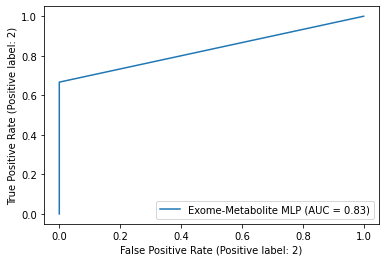

In [ ]:
y_pred2 = mlp_C_smote_model.predict(X_test_C_sm)
print(test_metrics(y_test_C_sm, y_pred2))

y_pred2 = mlp_C_smote_model.predict(X_train_C_sm)
print(test_metrics(y_train_C_sm, y_pred2))

mlp_c = RocCurveDisplay.from_estimator(mlp_C_smote_model, X_test_C_sm, y_test_C_sm, name="Exome-Metabolite MLP")
# Why is testing 100% Should I chnage the seed for random resample?

In [ ]:
from xgboost import XGBClassifier
import xgboost

model = XGBClassifier()


xg_pipe = Pipeline(steps=[('xg', XGBClassifier())])


param_grid = {}
#    'n_estimators': [10, 100, 500]
#}

xg = GridSearchCV(xg_pipe, param_grid, cv=cv, scoring=scoringa, refit=metric_used, return_train_score=True)
xg_model = xg.fit(X_train_C, y_train_C)

xg_pred = xg_model.predict(X_test_C_sm)

print(xg_model.best_estimator_)
print(test_metrics(y_test_C_sm, xg_pred))


Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV 1/10] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.005, n_estimators=25; accuracy: (train=1.000, test=0.333) f1_score: (train=1.000, test=0.500) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.333) precision-recall: (train=0.500, test=0.333) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.000) total time=   0.0s
[CV 2/10] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.005, n_estimators=25; accuracy: (train=1.000, test=0.667) f1_score: (train=1.000, test=0.800) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.667) precision-recall: (train=0.450, test=0.667) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=1.00

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV 3/10] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.005, n_estimators=25; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.550, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s
[CV 4/10] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.005, n_estimators=25; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.667) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.500) precision-recall: (train=0.476, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.000) total time=   0.1s
[CV 5/10] END base_e

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV 6/10] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.005, n_estimators=25; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.476, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 7/10] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.005, n_estimators=25; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.429, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s
[CV 8/10] END base_e

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dis

[CV 10/10] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.005, n_estimators=25; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.524, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s
[CV 1/10] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=8, learning_rate=0.005, n_estimators=25; accuracy: (train=1.000, test=0.333) f1_score: (train=1.000, test=0.500) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.333) precision-recall: (train=0.500, test=0.333) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.000) total time=   0.0s
[CV 2/10] END base_

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV 4/10] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=8, learning_rate=0.005, n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.476, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 5/10] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=8, learning_rate=0.005, n_estimators=25; accuracy: (train=0.952, test=nan) f1_score: (train=0.941, test=nan) kappa: (train=0.901, test=nan) mcc: (train=0.906, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=0.889, test=nan) roc_auc: (train=0.944, test=nan) sensitivity: (train=0.889, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s
[CV 6/10] END base_e

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV 7/10] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=8, learning_rate=0.005, n_estimators=25; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.429, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s
[CV 8/10] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=8, learning_rate=0.005, n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.476, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 9/10] END base_e

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dis

[CV 10/10] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=8, learning_rate=0.005, n_estimators=25; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.524, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s
[CV 1/10] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=4, learning_rate=0.005, n_estimators=25; accuracy: (train=1.000, test=0.333) f1_score: (train=1.000, test=0.500) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.333) precision-recall: (train=0.500, test=0.333) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.000) total time=   0.0s
[CV 2/10] END base_

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV 4/10] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=4, learning_rate=0.005, n_estimators=25; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.667) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.500) precision-recall: (train=0.476, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.000) total time=   0.1s
[CV 5/10] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=4, learning_rate=0.005, n_estimators=25; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.429, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s
[CV 6/10] END base_e

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py", line 572, in roc_auc_score
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_base.py", line 75, in _average_binary_score
    return binary_metric(y_tr

[CV 7/10] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=4, learning_rate=0.005, n_estimators=25; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.429, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s
[CV 8/10] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=4, learning_rate=0.005, n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.476, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 9/10] END base_e

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV 10/10] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=4, learning_rate=0.005, n_estimators=25; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.524, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s
[CV 1/10] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=8, learning_rate=0.005, n_estimators=25; accuracy: (train=1.000, test=0.333) f1_score: (train=1.000, test=0.500) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.333) precision-recall: (train=0.500, test=0.333) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.000) total time=   0.0s
[CV 2/10] END base_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py", line 572, in roc_auc_score
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_base.py", line 75, in _average_binary_score
    return binary_metric(y_tr

[CV 7/10] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=8, learning_rate=0.005, n_estimators=25; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.429, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s
[CV 8/10] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=8, learning_rate=0.005, n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.476, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 9/10] END base_e

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dis

[CV 10/10] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=8, learning_rate=0.005, n_estimators=25; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.524, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s


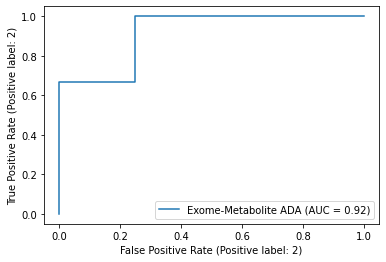

In [ ]:
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3))

parameters = {'base_estimator__max_depth':[3,5],
              'base_estimator__min_samples_leaf':[4,8],
              'n_estimators':[25],
              'learning_rate':[0.005]}

clf = GridSearchCV(abc, parameters,verbose=3, cv=cv, scoring=scoringa, refit=metric_used, return_train_score=True)
ada_model = clf.fit(X_train_C_sm,y_train_C_sm)

roc = RocCurveDisplay.from_estimator(ada_model, X_test_C_sm, y_test_C_sm, name="Exome-Metabolite ADA", pos_label=2)

['acc: 0.8571' 'percision: 1.0000' 'recall: 0.7500' 'F1: 0.8571'
 'ROC_AUC: 0.8750' '0.4911' '0.7500' '0.7200' '0.7500' '1.0000']
['acc: 1.0000' 'percision: 1.0000' 'recall: 1.0000' 'F1: 1.0000'
 'ROC_AUC: 1.0000' '0.4783' '1.0000' '1.0000' '1.0000' '1.0000']


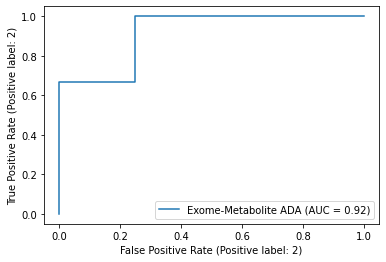

In [ ]:
y_pred2 = ada_model.predict(X_test_C_sm)
print(test_metrics(y_test_C_sm, y_pred2))

y_pred2 = ada_model.predict(X_train_C_sm)
print(test_metrics(y_train_C_sm, y_pred2))

mlp_c = RocCurveDisplay.from_estimator(ada_model, X_test_C_sm, y_test_C_sm, name="Exome-Metabolite ADA")

(23, 600)
[[3 1]
 [1 2]]


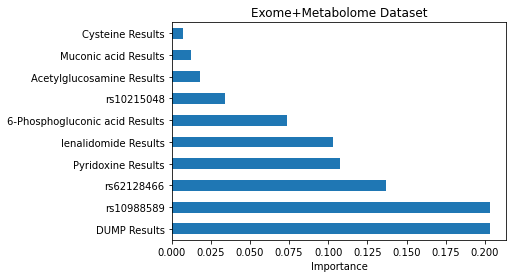

[3 2 1]
[0.   0.25 1.  ]
[0.         0.66666667 1.        ]


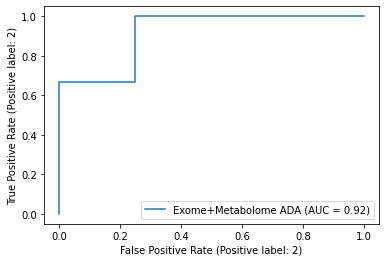

In [ ]:

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification

#print(ada_model.best_estimator_)
print(X_train_C_sm.shape)
ada_model2 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3, min_samples_leaf=4), learning_rate=0.005, n_estimators=25, random_state=42)
ada_model = ada_model2.fit(X_train_C_sm, y_train_C_sm)

yee = ada_model.predict(X_test_C_sm)

# confusion_matrix(y_true, y_pred)
print(confusion_matrix(y_test_C_sm, yee))
#print(ada_model.feature_importances_)
#print(X_combo)
feat_importances = pd.Series(ada_model.feature_importances_, index=combo2.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Importance')
plt.title('Exome+Metabolome Dataset')
plt.show()

fpr, tpr, x = metrics.roc_curve(y_test_C_sm,  yee, pos_label=2)
print(x)
auc = metrics.roc_auc_score(y_test_C_sm,  yee)
print(fpr)
print(tpr)

#create ROC curve
#plt.plot(fpr,tpr,label="2")
#plt.ylabel('True Positive Rate')
#plt.xlabel('False Positive Rate')
#plt.title('Exome+Metabalome Dataset')
#plt.show()

#roc = RocCurveDisplay.from_estimator(ada_model, X_test_C_sm, y_test_C_sm, name="Exome-Metabolite ADA", response_method='auto', drop_intermediate=False, pos_label=2)
roc = RocCurveDisplay.from_estimator(ada_model, X_test_C_sm, y_test_C_sm, name="Exome+Metabolome ADA", pos_label=2)

In [ ]:
### Random Forest ###
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline, make_pipeline

# Random Forest
rf_pipe = Pipeline(steps=[('rf', RandomForestClassifier(random_state=1))])
param_grid = {'rf__n_estimators': [2, 5,10], 'rf__max_depth': [3, 5] }
rf_model = GridSearchCV(rf_pipe, param_grid, cv=cv, scoring=scoringa, refit=metric_used, return_train_score=True, verbose=2)

#with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
#rf_C_model = rf_model.fit(X_train_C, y_train_C)

rf_C_smote_model = rf_model.fit(X_train_C_sm, y_train_C_sm)

print("Best estimator found by grid search:")
print(rf_C_smote_model.best_estimator_)
# RESULT: Pipeline(steps=[('rf', RandomForestClassifier(max_depth=3, n_estimators=25))])
# SMOTE RESULT: Pipeline(steps=[('rf', RandomForestClassifier(max_depth=3, n_estimators=50))])


Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] END ................rf__max_depth=3, rf__n_estimators=2; total time=   0.0s
[CV] END ................rf__max_depth=3, rf__n_estimators=2; total time=   0.0s
[CV] END ................rf__max_depth=3, rf__n_estimators=2; total time=   0.0s
[CV] END ................rf__max_depth=3, rf__n_estimators=2; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV] END ................rf__max_depth=3, rf__n_estimators=2; total time=   0.0s
[CV] END ................rf__max_depth=3, rf__n_estimators=2; total time=   0.0s
[CV] END ................rf__max_depth=3, rf__n_estimators=2; total time=   0.0s
[CV] END ................rf__max_depth=3, rf__n_estimators=2; total time=   0.0s
[CV] END ................rf__max_depth=3, rf__n_estimators=2; total time=   0.0s
[CV] END ................rf__max_depth=3, rf__n_estimators=2; total time=   0.0s
[CV] END ................rf__max_depth=3, rf__n_estimators=5; total time=   0.0s
[CV] END ................rf__max_depth=3, rf__n_estimators=5; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV] END ................rf__max_depth=3, rf__n_estimators=5; total time=   0.0s
[CV] END ................rf__max_depth=3, rf__n_estimators=5; total time=   0.0s
[CV] END ................rf__max_depth=3, rf__n_estimators=5; total time=   0.0s
[CV] END ................rf__max_depth=3, rf__n_estimators=5; total time=   0.1s
[CV] END ................rf__max_depth=3, rf__n_estimators=5; total time=   0.0s
[CV] END ................rf__max_depth=3, rf__n_estimators=5; total time=   0.0s
[CV] END ................rf__max_depth=3, rf__n_estimators=5; total time=   0.0s
[CV] END ................rf__max_depth=3, rf__n_estimators=5; total time=   0.0s
[CV] END ...............rf__max_depth=3, rf__n_estimators=10; total time=   0.0s
[CV] END ...............rf__max_depth=3, rf__n_estimators=10; total time=   0.0s
[CV] END ...............rf__max_depth=3, rf__n_estimators=10; total time=   0.0s
[CV] END ...............rf__max_depth=3, rf__n_estimators=10; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV] END ...............rf__max_depth=3, rf__n_estimators=10; total time=   0.1s
[CV] END ...............rf__max_depth=3, rf__n_estimators=10; total time=   0.1s
[CV] END ...............rf__max_depth=3, rf__n_estimators=10; total time=   0.0s
[CV] END ...............rf__max_depth=3, rf__n_estimators=10; total time=   0.0s
[CV] END ...............rf__max_depth=3, rf__n_estimators=10; total time=   0.1s
[CV] END ...............rf__max_depth=3, rf__n_estimators=10; total time=   0.0s
[CV] END ................rf__max_depth=5, rf__n_estimators=2; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dis

[CV] END ................rf__max_depth=5, rf__n_estimators=2; total time=   0.0s
[CV] END ................rf__max_depth=5, rf__n_estimators=2; total time=   0.0s
[CV] END ................rf__max_depth=5, rf__n_estimators=2; total time=   0.0s
[CV] END ................rf__max_depth=5, rf__n_estimators=2; total time=   0.0s
[CV] END ................rf__max_depth=5, rf__n_estimators=2; total time=   0.0s
[CV] END ................rf__max_depth=5, rf__n_estimators=2; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. Th

[CV] END ................rf__max_depth=5, rf__n_estimators=2; total time=   0.0s
[CV] END ................rf__max_depth=5, rf__n_estimators=2; total time=   0.0s
[CV] END ................rf__max_depth=5, rf__n_estimators=2; total time=   0.0s
[CV] END ................rf__max_depth=5, rf__n_estimators=5; total time=   0.0s
[CV] END ................rf__max_depth=5, rf__n_estimators=5; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV] END ................rf__max_depth=5, rf__n_estimators=5; total time=   0.0s
[CV] END ................rf__max_depth=5, rf__n_estimators=5; total time=   0.0s
[CV] END ................rf__max_depth=5, rf__n_estimators=5; total time=   0.0s
[CV] END ................rf__max_depth=5, rf__n_estimators=5; total time=   0.0s
[CV] END ................rf__max_depth=5, rf__n_estimators=5; total time=   0.0s
[CV] END ................rf__max_depth=5, rf__n_estimators=5; total time=   0.0s
[CV] END ................rf__max_depth=5, rf__n_estimators=5; total time=   0.0s
[CV] END ................rf__max_depth=5, rf__n_estimators=5; total time=   0.0s
[CV] END ...............rf__max_depth=5, rf__n_estimators=10; total time=   0.0s
[CV] END ...............rf__max_depth=5, rf__n_estimators=10; total time=   0.0s
[CV] END ...............rf__max_depth=5, rf__n_estimators=10; total time=   0.1s
[CV] END ...............rf__max_depth=5, rf__n_estimators=10; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV] END ...............rf__max_depth=5, rf__n_estimators=10; total time=   0.1s
[CV] END ...............rf__max_depth=5, rf__n_estimators=10; total time=   0.0s
[CV] END ...............rf__max_depth=5, rf__n_estimators=10; total time=   0.0s
[CV] END ...............rf__max_depth=5, rf__n_estimators=10; total time=   0.1s
[CV] END ...............rf__max_depth=5, rf__n_estimators=10; total time=   0.0s
[CV] END ...............rf__max_depth=5, rf__n_estimators=10; total time=   0.0s
Best estimator found by grid search:
Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, n_estimators=2,
                                        random_state=1))])


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  category=UserWarning,


In [ ]:
#print(y_test_C, y_test_C_sm)
y_pred_sm_rf = rf_C_smote_model.predict(X_test_C_sm)
print(test_metrics(y_test_C_sm, y_pred_sm_rf))

y_pred_sm_rf = rf_C_smote_model.predict(X_train_C)
print(test_metrics(y_train_C, y_pred_sm_rf))



['acc: 0.7143' 'percision: 0.6667' 'recall: 1.0000' 'F1: 0.8000'
 'ROC_AUC: 0.6667' '0.5714' '0.4714' '0.3636' '1.0000' '0.3333']
['acc: 0.8000' 'percision: 0.5000' 'recall: 1.0000' 'F1: 0.6667'
 'ROC_AUC: 0.8750' '0.2000' '0.6124' '0.5455' '1.0000' '0.7500']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


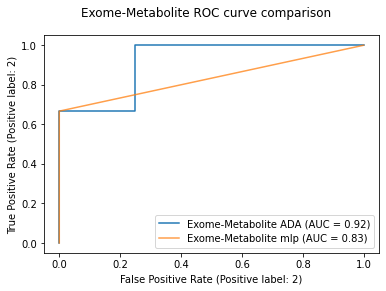

In [ ]:
c = RocCurveDisplay.from_estimator(ada_model, X_test_C_sm, y_test_C_sm, name="Exome-Metabolite ADA", alpha=0.99)

#c = plot_roc_curve(rf_C_smote_model, X_test_C_sm, y_test_C_sm, name="Exome-Metabolite RF", ax=c.ax_, alpha=0.75)

#c = plot_roc_curve(xg_model, X_test_C_sm, y_test_C_sm, name="Exome-Metabolite XG", ax=c.ax_)

c = plot_roc_curve(mlp_C_smote_model, X_test_C_sm, y_test_C_sm, name="Exome-Metabolite mlp", ax=c.ax_, alpha=0.75).figure_.suptitle("Exome-Metabolite ROC curve comparison")

# **DECISION-FUSION**  ⚡💯⚡

In [ ]:
### Desicion level
# Combine at the final decision level
# AdaBoost? Stacking? Genetic Algorithm-based Classifier Ensemble Optimization Method?

### STACKING ###
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

#Define SMOTE-ENN
#resample=SMOTEENN(enn=EditedNearestNeighbours(n_neighbors=1, sampling_strategy='all'))

# Random Forrest
#rf_pipe = Pipeline(steps=[('r', resample), ('rf', RandomForestClassifier())])
rf_pipe = Pipeline(steps=[('rf', RandomForestClassifier())])
param_grid = {'rf__n_estimators': [25], 'rf__max_depth': [3] }
rf_model = GridSearchCV(rf_pipe, param_grid, cv=cv, scoring=scoringa, refit=metric_used, return_train_score=True, verbose=3)
rf_G_model = rf_model.fit(X_train_G_sm, y_train_G_sm)


print("Best estimator found by grid search:")
print(rf_G_model.best_estimator_)
# RESULT: Pipeline(steps=[('rf', RandomForestClassifier(max_depth=3, n_estimators=25))])



Fitting 100 folds for each of 1 candidates, totalling 100 fits
[CV 1/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.488, test=0.600) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 2/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.889) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.800) precision-recall: (train=0.463, test=0.800) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.000) total time=   0.1s


/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 3/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.512, test=0.400) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 4/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.600) f1_score: (train=1.000, test=0.500) kappa: (train=1.000, test=0.167) mcc: (train=1.000, test=0.167) precision: (train=1.000, test=0.500) precision-recall: (train=0.512, test=0.367) recall: (train=1.000, test=0.500) roc_auc: (train=1.000, test=0.583) sensitivity: (train=1.000, test=0.500) specificity: (train=1.000, test=0.667) total time=   0.1s
[CV 5/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.857) kap

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no tru


[CV 7/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.500, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 8/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.800) kappa: (train=1.000, test=0.500) mcc: (train=1.000, test=0.577) precision: (train=1.000, test=1.000) precision-recall: (train=0.476, test=0.667) recall: (train=1.000, test=0.667) roc_auc: (train=1.000, test=0.833) sensitivity: (train=1.000, test=0.667) specificity: (train=1.000, test=1.000) total time=   0.1s


/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 9/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.250) f1_score: (train=1.000, test=0.400) kappa: (train=1.000, test=-0.500) mcc: (train=1.000, test=-0.577) precision: (train=1.000, test=0.500) precision-recall: (train=0.476, test=0.917) recall: (train=1.000, test=0.333) roc_auc: (train=1.000, test=0.167) sensitivity: (train=1.000, test=0.333) specificity: (train=1.000, test=0.000) total time=   0.1s
[CV 10/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.500) kappa: (train=1.000, test=0.200) mcc: (train=1.000, test=0.333) precision: (train=1.000, test=0.333) precision-recall: (train=0.524, test=0.250) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.667) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.333) total time=   0.1s
[CV 11/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.400) f1_score: (train=1.000, test=0.400)

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 12/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=0.976, test=0.800) f1_score: (train=0.977, test=0.667) kappa: (train=0.951, test=0.545) mcc: (train=0.952, test=0.612) precision: (train=0.955, test=1.000) precision-recall: (train=0.512, test=0.325) recall: (train=1.000, test=0.500) roc_auc: (train=0.975, test=0.750) sensitivity: (train=1.000, test=0.500) specificity: (train=0.950, test=1.000) total time=   0.1s
[CV 13/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.600) f1_score: (train=1.000, test=0.500) kappa: (train=1.000, test=0.167) mcc: (train=1.000, test=0.167) precision: (train=1.000, test=0.500) precision-recall: (train=0.512, test=0.367) recall: (train=1.000, test=0.500) roc_auc: (train=1.000, test=0.583) sensitivity: (train=1.000, test=0.500) specificity: (train=1.000, test=0.667) total time=   0.1s
[CV 14/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.667) 

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 15/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.889) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.800) precision-recall: (train=0.463, test=0.800) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.000) total time=   0.1s
[CV 16/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=0.976, test=nan) f1_score: (train=0.971, test=nan) kappa: (train=0.950, test=nan) mcc: (train=0.951, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.417, test=nan) recall: (train=0.944, test=nan) roc_auc: (train=0.972, test=nan) sensitivity: (train=0.944, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s
[CV 17/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000,

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kw

[CV 18/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.500) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.500) precision-recall: (train=0.500, test=0.500) recall: (train=1.000, test=0.500) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.500) specificity: (train=1.000, test=0.500) total time=   0.1s
[CV 19/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.500) kappa: (train=1.000, test=0.200) mcc: (train=1.000, test=0.333) precision: (train=1.000, test=0.333) precision-recall: (train=0.524, test=0.250) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.667) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.333) total time=   0.1s
[CV 20/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.800) 

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 21/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.600) f1_score: (train=1.000, test=0.667) kappa: (train=1.000, test=0.167) mcc: (train=1.000, test=0.167) precision: (train=1.000, test=0.667) precision-recall: (train=0.488, test=0.567) recall: (train=1.000, test=0.667) roc_auc: (train=1.000, test=0.583) sensitivity: (train=1.000, test=0.667) specificity: (train=1.000, test=0.500) total time=   0.1s
[CV 22/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.537, test=0.200) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 23/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.400) f1_score: (train=1.000, test=0.400) 

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 24/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.667) kappa: (train=1.000, test=0.545) mcc: (train=1.000, test=0.612) precision: (train=1.000, test=1.000) precision-recall: (train=0.512, test=0.325) recall: (train=1.000, test=0.500) roc_auc: (train=1.000, test=0.750) sensitivity: (train=1.000, test=0.500) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 25/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.400) f1_score: (train=1.000, test=0.400) kappa: (train=1.000, test=-0.154) mcc: (train=1.000, test=-0.167) precision: (train=1.000, test=0.500) precision-recall: (train=0.488, test=0.644) recall: (train=1.000, test=0.333) roc_auc: (train=1.000, test=0.417) sensitivity: (train=1.000, test=0.333) specificity: (train=1.000, test=0.500) total time=   0.1s
[CV 26/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 27/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.800) kappa: (train=1.000, test=0.500) mcc: (train=1.000, test=0.577) precision: (train=1.000, test=1.000) precision-recall: (train=0.476, test=0.667) recall: (train=1.000, test=0.667) roc_auc: (train=1.000, test=0.833) sensitivity: (train=1.000, test=0.667) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 28/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.500, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 29/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.800) 

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 30/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.800) kappa: (train=1.000, test=0.500) mcc: (train=1.000, test=0.577) precision: (train=1.000, test=1.000) precision-recall: (train=0.476, test=0.667) recall: (train=1.000, test=0.667) roc_auc: (train=1.000, test=0.833) sensitivity: (train=1.000, test=0.667) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 31/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=0.976, test=0.600) f1_score: (train=0.978, test=0.500) kappa: (train=0.951, test=0.286) mcc: (train=0.952, test=0.408) precision: (train=0.957, test=0.333) precision-recall: (train=0.537, test=0.200) recall: (train=1.000, test=1.000) roc_auc: (train=0.974, test=0.750) sensitivity: (train=1.000, test=1.000) specificity: (train=0.947, test=0.500) total time=   0.1s
[CV 32/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.200) f1_score: (train=1.000, test=0.333) 

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 33/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.537, test=0.200) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 34/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.600) f1_score: (train=1.000, test=0.667) kappa: (train=1.000, test=0.286) mcc: (train=1.000, test=0.408) precision: (train=1.000, test=1.000) precision-recall: (train=0.463, test=0.733) recall: (train=1.000, test=0.500) roc_auc: (train=1.000, test=0.750) sensitivity: (train=1.000, test=0.500) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 35/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.857) 

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 36/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.800) kappa: (train=1.000, test=0.615) mcc: (train=1.000, test=0.667) precision: (train=1.000, test=1.000) precision-recall: (train=0.488, test=0.511) recall: (train=1.000, test=0.667) roc_auc: (train=1.000, test=0.833) sensitivity: (train=1.000, test=0.667) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 37/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.800) kappa: (train=1.000, test=0.500) mcc: (train=1.000, test=0.577) precision: (train=1.000, test=1.000) precision-recall: (train=0.476, test=0.667) recall: (train=1.000, test=0.667) roc_auc: (train=1.000, test=0.833) sensitivity: (train=1.000, test=0.667) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 38/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.500) 

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 39/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.667) kappa: (train=1.000, test=-0.333) mcc: (train=1.000, test=-0.333) precision: (train=1.000, test=0.667) precision-recall: (train=0.476, test=0.833) recall: (train=1.000, test=0.667) roc_auc: (train=1.000, test=0.333) sensitivity: (train=1.000, test=0.667) specificity: (train=1.000, test=0.000) total time=   0.1s
[CV 40/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.500, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 41/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.600) f1_score: (train=1.000, test=0.500

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 42/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.800) kappa: (train=1.000, test=0.615) mcc: (train=1.000, test=0.667) precision: (train=1.000, test=0.667) precision-recall: (train=0.512, test=0.400) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.833) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.667) total time=   0.1s
[CV 43/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.600) f1_score: (train=1.000, test=0.500) kappa: (train=1.000, test=0.167) mcc: (train=1.000, test=0.167) precision: (train=1.000, test=0.500) precision-recall: (train=0.512, test=0.367) recall: (train=1.000, test=0.500) roc_auc: (train=1.000, test=0.583) sensitivity: (train=1.000, test=0.500) specificity: (train=1.000, test=0.667) total time=   0.1s
[CV 44/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.667) 

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 45/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.667) kappa: (train=1.000, test=0.545) mcc: (train=1.000, test=0.612) precision: (train=1.000, test=1.000) precision-recall: (train=0.512, test=0.325) recall: (train=1.000, test=0.500) roc_auc: (train=1.000, test=0.750) sensitivity: (train=1.000, test=0.500) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 46/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.488, test=0.600) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 47/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.800) 

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 48/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.500) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.500) precision-recall: (train=0.500, test=0.500) recall: (train=1.000, test=0.500) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.500) specificity: (train=1.000, test=0.500) total time=   0.1s
[CV 49/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.500) kappa: (train=1.000, test=0.200) mcc: (train=1.000, test=0.333) precision: (train=1.000, test=1.000) precision-recall: (train=0.476, test=0.694) recall: (train=1.000, test=0.333) roc_auc: (train=1.000, test=0.667) sensitivity: (train=1.000, test=0.333) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 50/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) 

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 52/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.488, test=0.600) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 53/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.800) kappa: (train=1.000, test=0.615) mcc: (train=1.000, test=0.667) precision: (train=1.000, test=0.667) precision-recall: (train=0.512, test=0.400) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.833) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.667) total time=   0.1s
[CV 54/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.667) 

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 55/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.400) f1_score: (train=1.000, test=0.400) kappa: (train=1.000, test=0.118) mcc: (train=1.000, test=0.250) precision: (train=1.000, test=0.250) precision-recall: (train=0.537, test=0.200) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.625) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.250) total time=   0.1s
[CV 56/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.667) kappa: (train=1.000, test=0.545) mcc: (train=1.000, test=0.612) precision: (train=1.000, test=1.000) precision-recall: (train=0.512, test=0.325) recall: (train=1.000, test=0.500) roc_auc: (train=1.000, test=0.750) sensitivity: (train=1.000, test=0.500) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 57/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.667) 

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 58/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.667) kappa: (train=1.000, test=0.500) mcc: (train=1.000, test=0.577) precision: (train=1.000, test=1.000) precision-recall: (train=0.500, test=0.417) recall: (train=1.000, test=0.500) roc_auc: (train=1.000, test=0.750) sensitivity: (train=1.000, test=0.500) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 59/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.500) kappa: (train=1.000, test=0.200) mcc: (train=1.000, test=0.333) precision: (train=1.000, test=1.000) precision-recall: (train=0.476, test=0.694) recall: (train=1.000, test=0.333) roc_auc: (train=1.000, test=0.667) sensitivity: (train=1.000, test=0.333) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 60/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) 

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 61/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.667) kappa: (train=1.000, test=0.545) mcc: (train=1.000, test=0.612) precision: (train=1.000, test=1.000) precision-recall: (train=0.512, test=0.325) recall: (train=1.000, test=0.500) roc_auc: (train=1.000, test=0.750) sensitivity: (train=1.000, test=0.500) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 62/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.488, test=0.600) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 63/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) 

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 64/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.400) f1_score: (train=1.000, test=0.400) kappa: (train=1.000, test=0.118) mcc: (train=1.000, test=0.250) precision: (train=1.000, test=0.250) precision-recall: (train=0.537, test=0.200) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.625) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.250) total time=   0.1s
[CV 65/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.857) kappa: (train=1.000, test=0.545) mcc: (train=1.000, test=0.612) precision: (train=1.000, test=1.000) precision-recall: (train=0.463, test=0.725) recall: (train=1.000, test=0.750) roc_auc: (train=1.000, test=0.875) sensitivity: (train=1.000, test=0.750) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 66/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.600) f1_score: (train=1.000, test=0.667) 

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 67/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.500) kappa: (train=1.000, test=0.200) mcc: (train=1.000, test=0.333) precision: (train=1.000, test=0.333) precision-recall: (train=0.524, test=0.250) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.667) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.333) total time=   0.1s
[CV 68/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.500) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.500) precision-recall: (train=0.500, test=0.500) recall: (train=1.000, test=0.500) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.500) specificity: (train=1.000, test=0.500) total time=   0.1s
[CV 69/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) 

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 70/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.500, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 71/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.512, test=0.400) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 72/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=0.976, test=0.800) f1_score: (train=0.976, test=0.667) 

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 73/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.857) kappa: (train=1.000, test=0.545) mcc: (train=1.000, test=0.612) precision: (train=1.000, test=1.000) precision-recall: (train=0.463, test=0.725) recall: (train=1.000, test=0.750) roc_auc: (train=1.000, test=0.875) sensitivity: (train=1.000, test=0.750) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 74/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.400) f1_score: (train=1.000, test=0.400) kappa: (train=1.000, test=-0.154) mcc: (train=1.000, test=-0.167) precision: (train=1.000, test=0.333) precision-recall: (train=0.512, test=0.450) recall: (train=1.000, test=0.500) roc_auc: (train=1.000, test=0.417) sensitivity: (train=1.000, test=0.500) specificity: (train=1.000, test=0.333) total time=   0.1s
[CV 75/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.667

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 76/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.400) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=-0.364) mcc: (train=1.000, test=-0.408) precision: (train=1.000, test=0.000) precision-recall: (train=0.537, test=0.333) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.250) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=0.500) total time=   0.1s
[CV 77/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.800) kappa: (train=1.000, test=0.500) mcc: (train=1.000, test=0.577) precision: (train=1.000, test=0.667) precision-recall: (train=0.500, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.750) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.500) total time=   0.1s
[CV 78/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.500

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kw

[CV 79/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.452, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.0s
[CV 80/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.500, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 81/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.800) kappa: (train=1.000,

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 82/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.537, test=0.200) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 83/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.600) f1_score: (train=1.000, test=0.667) kappa: (train=1.000, test=0.167) mcc: (train=1.000, test=0.167) precision: (train=1.000, test=0.667) precision-recall: (train=0.488, test=0.567) recall: (train=1.000, test=0.667) roc_auc: (train=1.000, test=0.583) sensitivity: (train=1.000, test=0.667) specificity: (train=1.000, test=0.500) total time=   0.1s
[CV 84/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.600) f1_score: (train=1.000, test=0.667) 

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 85/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.667) kappa: (train=1.000, test=0.545) mcc: (train=1.000, test=0.612) precision: (train=1.000, test=0.500) precision-recall: (train=0.537, test=0.200) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.875) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.750) total time=   0.1s
[CV 86/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.800) kappa: (train=1.000, test=0.615) mcc: (train=1.000, test=0.667) precision: (train=1.000, test=1.000) precision-recall: (train=0.488, test=0.511) recall: (train=1.000, test=0.667) roc_auc: (train=1.000, test=0.833) sensitivity: (train=1.000, test=0.667) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 87/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.667) 

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

[CV 88/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.250) f1_score: (train=1.000, test=0.400) kappa: (train=1.000, test=-0.500) mcc: (train=1.000, test=-0.577) precision: (train=1.000, test=0.333) precision-recall: (train=0.500, test=0.750) recall: (train=1.000, test=0.500) roc_auc: (train=1.000, test=0.250) sensitivity: (train=1.000, test=0.500) specificity: (train=1.000, test=0.000) total time=   0.1s
[CV 89/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.500, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 90/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.800

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 91/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.857) kappa: (train=1.000, test=0.545) mcc: (train=1.000, test=0.612) precision: (train=1.000, test=1.000) precision-recall: (train=0.463, test=0.725) recall: (train=1.000, test=0.750) roc_auc: (train=1.000, test=0.875) sensitivity: (train=1.000, test=0.750) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 92/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.400) f1_score: (train=1.000, test=0.400) kappa: (train=1.000, test=-0.154) mcc: (train=1.000, test=-0.167) precision: (train=1.000, test=0.333) precision-recall: (train=0.512, test=0.450) recall: (train=1.000, test=0.500) roc_auc: (train=1.000, test=0.417) sensitivity: (train=1.000, test=0.500) specificity: (train=1.000, test=0.333) total time=   0.1s
[CV 93/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.667

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 94/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.512, test=0.400) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 95/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.600) f1_score: (train=1.000, test=0.667) kappa: (train=1.000, test=0.286) mcc: (train=1.000, test=0.408) precision: (train=1.000, test=0.500) precision-recall: (train=0.512, test=0.400) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.667) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.333) total time=   0.1s
[CV 96/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.200) f1_score: (train=1.000, test=0.000) 

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV 97/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.524, test=0.250) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 98/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.500) kappa: (train=1.000, test=0.200) mcc: (train=1.000, test=0.333) precision: (train=1.000, test=1.000) precision-recall: (train=0.476, test=0.694) recall: (train=1.000, test=0.333) roc_auc: (train=1.000, test=0.667) sensitivity: (train=1.000, test=0.333) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 99/100] END rf__max_depth=3, rf__n_estimators=25; accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.857) 

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan]
  category=UserWarning,
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


In [ ]:
y_hat_RF = rf_G_model.predict(X_test_G_sm)
print(test_metrics(y_test_G_sm, y_hat_RF))
#print(test_metrics(y_test_C, y_hat_RF))

['acc: 0.7500' 'percision: 0.7143' 'recall: 0.8333' 'F1: 0.7692'
 'ROC_AUC: 0.7500' '0.4500' '0.5071' '0.5000' '0.8333' '0.6667']


In [ ]:
# Random Forrest
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

#Define SMOTE-ENN
#resample=SMOTEENN(enn=EditedNearestNeighbours(n_neighbors=1, sampling_strategy='all'))

#rf_pipe = Pipeline(steps=[('r', resample), ('rf', RandomForestClassifier())])
rf_pipe = Pipeline(steps=[('rf', RandomForestClassifier(random_state=0))])
param_grid = {'rf__n_estimators': [7, 15, 20], 'rf__max_depth': [3, 4, 6], }
rf_model = GridSearchCV(rf_pipe, param_grid, cv=cv, scoring=scoringa, refit=metric_used, return_train_score=True, verbose=3)
rf_M_model = rf_model.fit(X_train_M_sm, y_train_M_sm)


print("---\n---\nBest estimator found by grid search:")
print(rf_M_model.best_estimator_)
# RESULT: Pipeline(steps=[('rf', RandomForestClassifier(max_depth=3, n_estimators=25))])

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV 1/10] END rf__max_depth=3, rf__n_estimators=7; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV 2/10] END rf__max_depth=3, rf__n_estimators=7; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 3/10] END rf__max_depth=3, rf__n_estimators=7; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV 4/10] END rf__max_depth=3, rf__n_estimators=7; accuracy: (train=0.944, test=0.500) f1_score: (train=0.923, test=0.000) kappa: (train=0.880, test=0.000) mcc: (train=0.886, test=0.000) precision: (train=0.857, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=0.958, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=0.917, test=1.000) total time=   0.1s
[CV 5/10] END rf__max_depth=3, rf__n_estimators=7; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV 6/10] END rf__max_depth=3, rf__n_estimators=7; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.278, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s
[CV 7/10] END rf__max_depth=3, rf__n_estimators=7; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being s

[CV 8/10] END rf__max_depth=3, rf__n_estimators=7; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 9/10] END rf__max_depth=3, rf__n_estimators=7; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s
[CV 10/10] END rf__max_depth=3, rf__n_estimators=7; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. Th

[CV 1/10] END rf__max_depth=3, rf__n_estimators=15; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s
[CV 2/10] END rf__max_depth=3, rf__n_estimators=15; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV 3/10] END rf__max_depth=3, rf__n_estimators=15; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s
[CV 4/10] END rf__max_depth=3, rf__n_estimators=15; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/10] END rf__max_depth=3, rf__n_estimators=15; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 6/10] END rf__max_depth=3, rf__n_estimators=15; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.278, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py", line 572, in roc_auc_score
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_base.py", line 75, in _average_binary_score
    return binary_metric(y_tr

[CV 7/10] END rf__max_depth=3, rf__n_estimators=15; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s
[CV 8/10] END rf__max_depth=3, rf__n_estimators=15; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being s

[CV 9/10] END rf__max_depth=3, rf__n_estimators=15; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being s

[CV 10/10] END rf__max_depth=3, rf__n_estimators=15; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.2s
[CV 1/10] END rf__max_depth=3, rf__n_estimators=20; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dis

[CV 2/10] END rf__max_depth=3, rf__n_estimators=20; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 3/10] END rf__max_depth=3, rf__n_estimators=20; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s
[CV 4/10] END rf__max_depth=3, rf__n_estimators=20; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/pytho

[CV 6/10] END rf__max_depth=3, rf__n_estimators=20; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.278, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s
[CV 7/10] END rf__max_depth=3, rf__n_estimators=20; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV 8/10] END rf__max_depth=3, rf__n_estimators=20; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 9/10] END rf__max_depth=3, rf__n_estimators=20; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. Th

[CV 10/10] END rf__max_depth=3, rf__n_estimators=20; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 1/10] END rf__max_depth=4, rf__n_estimators=7; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.0s
[CV 2/10] END rf__max_depth=4, rf__n_estimators=7; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dis

[CV 4/10] END rf__max_depth=4, rf__n_estimators=7; accuracy: (train=0.944, test=0.500) f1_score: (train=0.923, test=0.000) kappa: (train=0.880, test=0.000) mcc: (train=0.886, test=0.000) precision: (train=0.857, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=0.958, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=0.917, test=1.000) total time=   0.0s
[CV 5/10] END rf__max_depth=4, rf__n_estimators=7; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.0s
[CV 6/10] END rf__max_depth=4, rf__n_estimators=7; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV 8/10] END rf__max_depth=4, rf__n_estimators=7; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.0s
[CV 9/10] END rf__max_depth=4, rf__n_estimators=7; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.0s
[CV 10/10] END rf__max_depth=4, rf__n_estimators=7; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being s

[CV 2/10] END rf__max_depth=4, rf__n_estimators=15; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.0s
[CV 3/10] END rf__max_depth=4, rf__n_estimators=15; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.0s
[CV 4/10] END rf__max_depth=4, rf__n_estimators=15; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this 

[CV 7/10] END rf__max_depth=4, rf__n_estimators=15; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.0s
[CV 8/10] END rf__max_depth=4, rf__n_estimators=15; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.0s
[CV 9/10] END rf__max_depth=4, rf__n_estimators=15; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. Th

[CV 2/10] END rf__max_depth=4, rf__n_estimators=20; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 3/10] END rf__max_depth=4, rf__n_estimators=20; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.0s
[CV 4/10] END rf__max_depth=4, rf__n_estimators=20; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV 6/10] END rf__max_depth=4, rf__n_estimators=20; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.278, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.0s
[CV 7/10] END rf__max_depth=4, rf__n_estimators=20; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s
[CV 8/10] END rf__max_depth=4, rf__n_estimators=20; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV 9/10] END rf__max_depth=4, rf__n_estimators=20; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s
[CV 10/10] END rf__max_depth=4, rf__n_estimators=20; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 1/10] END rf__max_depth=6, rf__n_estimators=7; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV 4/10] END rf__max_depth=6, rf__n_estimators=7; accuracy: (train=0.944, test=0.500) f1_score: (train=0.923, test=0.000) kappa: (train=0.880, test=0.000) mcc: (train=0.886, test=0.000) precision: (train=0.857, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=0.958, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=0.917, test=1.000) total time=   0.0s
[CV 5/10] END rf__max_depth=6, rf__n_estimators=7; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.0s
[CV 6/10] END rf__max_depth=6, rf__n_estimators=7; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV 10/10] END rf__max_depth=6, rf__n_estimators=7; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.0s
[CV 1/10] END rf__max_depth=6, rf__n_estimators=15; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.0s
[CV 2/10] END rf__max_depth=6, rf__n_estimators=15; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dis

[CV 5/10] END rf__max_depth=6, rf__n_estimators=15; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.0s
[CV 6/10] END rf__max_depth=6, rf__n_estimators=15; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.278, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.0s
[CV 7/10] END rf__max_depth=6, rf__n_estimators=15; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV 10/10] END rf__max_depth=6, rf__n_estimators=15; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.0s
[CV 1/10] END rf__max_depth=6, rf__n_estimators=20; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.0s
[CV 2/10] END rf__max_depth=6, rf__n_estimators=20; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. Th

[CV 4/10] END rf__max_depth=6, rf__n_estimators=20; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.0s
[CV 5/10] END rf__max_depth=6, rf__n_estimators=20; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 6/10] END rf__max_depth=6, rf__n_estimators=20; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (tr

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/pytho

[CV 8/10] END rf__max_depth=6, rf__n_estimators=20; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.0s
[CV 9/10] END rf__max_depth=6, rf__n_estimators=20; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s
[CV 10/10] END rf__max_depth=6, rf__n_estimators=20; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. Th

In [ ]:
y_hat_RF_M = rf_M_model.predict(X_test_M_sm)
print(test_metrics(y_test_M_sm, y_hat_RF_M))

y_hat_RF_M = rf_M_model.predict(X_train_M_sm)
print(test_metrics(y_train_M_sm, y_hat_RF_M))

['acc: 0.8571' 'percision: 1.0000' 'recall: 0.6667' 'F1: 0.8000'
 'ROC_AUC: 0.8333' '0.3524' '0.7303' '0.6957' '0.6667' '1.0000']
['acc: 0.7407' 'percision: 1.0000' 'recall: 0.5000' 'F1: 0.6667'
 'ROC_AUC: 0.7500' '0.4343' '0.5701' '0.4906' '0.5000' '1.0000']


In [ ]:
# NB
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline, make_pipeline

mnb_pipe = Pipeline(steps=[('gnb', GaussianNB())])

param_grid = {'gnb__var_smoothing': [1e-8, 1e-6]}

mnb = GridSearchCV(mnb_pipe, param_grid, cv=cv, scoring=scoringa, refit=metric_used, return_train_score=True, verbose=3)

mnb = mnb.fit(X_train_G, y_train_G)

print("Best estimator found by grid search: ")
print(mnb.best_estimator_)
#RESULT: Pipeline(steps=[('smote', SMOTE(random_state=42)), ('gnb', GaussianNB(var_smoothing=1e-08))])


Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 1/10] END gnb__var_smoothing=1e-08; accuracy: (train=0.771, test=0.750) f1_score: (train=0.778, test=0.800) kappa: (train=0.565, test=0.500) mcc: (train=0.628, test=0.577) precision: (train=0.636, test=0.667) precision-recall: (train=0.400, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=0.810, test=0.750) sensitivity: (train=1.000, test=1.000) specificity: (train=0.619, test=0.500) total time=   0.0s
[CV 2/10] END gnb__var_smoothing=1e-08; accuracy: (train=0.943, test=0.500) f1_score: (train=0.923, test=0.500) kappa: (train=0.878, test=0.000) mcc: (train=0.885, test=0.000) precision: (train=1.000, test=0.500) precision-recall: (train=0.355, test=0.500) recall: (train=0.857, test=0.500) roc_auc: (train=0.929, test=0.500) sensitivity: (train=0.857, test=0.500) specificity: (train=1.000, test=0.500) total time=   0.0s
[CV 3/10] END gnb__var_smoothing=1e-08; accuracy: (train=0.686, test=0.750) f1_score: (train=

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 9/10] END gnb__var_smoothing=1e-08; accuracy: (train=0.771, test=0.250) f1_score: (train=0.789, test=0.400) kappa: (train=0.562, test=0.000) mcc: (train=0.626, test=0.000) precision: (train=0.652, test=0.250) precision-recall: (train=0.429, test=0.250) recall: (train=1.000, test=1.000) roc_auc: (train=0.800, test=0.500) sensitivity: (train=1.000, test=1.000) specificity: (train=0.600, test=0.000) total time=   0.0s
[CV 10/10] END gnb__var_smoothing=1e-08; accuracy: (train=0.722, test=0.333) f1_score: (train=0.750, test=0.500) kappa: (train=0.478, test=0.000) mcc: (train=0.561, test=0.000) precision: (train=0.600, test=0.333) precision-recall: (train=0.417, test=0.333) recall: (train=1.000, test=1.000) roc_auc: (train=0.762, test=0.500) sensitivity: (train=1.000, test=1.000) specificity: (train=0.524, test=0.000) total time=   0.0s
[CV 1/10] END gnb__var_smoothing=1e-06; accuracy: (train=0.829, test=0.750) f1_score: (train=0.824, test=0.800) kappa: (train=0.667, test=0.500) mcc: (tr

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 8/10] END gnb__var_smoothing=1e-06; accuracy: (train=0.800, test=0.500) f1_score: (train=0.811, test=0.500) kappa: (train=0.614, test=0.200) mcc: (train=0.666, test=0.333) precision: (train=0.682, test=0.333) precision-recall: (train=0.429, test=0.250) recall: (train=1.000, test=1.000) roc_auc: (train=0.825, test=0.667) sensitivity: (train=1.000, test=1.000) specificity: (train=0.650, test=0.333) total time=   0.0s
[CV 9/10] END gnb__var_smoothing=1e-06; accuracy: (train=0.857, test=0.500) f1_score: (train=0.857, test=0.500) kappa: (train=0.720, test=0.200) mcc: (train=0.750, test=0.333) precision: (train=0.750, test=0.333) precision-recall: (train=0.429, test=0.250) recall: (train=1.000, test=1.000) roc_auc: (train=0.875, test=0.667) sensitivity: (train=1.000, test=1.000) specificity: (train=0.750, test=0.333) total time=   0.0s
[CV 10/10] END gnb__var_smoothing=1e-06; accuracy: (train=0.861, test=0.333) f1_score: (train=0.857, test=0.500) kappa: (train=0.727, test=0.000) mcc: (tr

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
y_pred = mnb.predict(X_test_G)

print(test_metrics(y_test_G, y_pred))

['acc: 0.7000' 'percision: 0.6000' 'recall: 0.7500' 'F1: 0.6667'
 'ROC_AUC: 0.7083' '0.3500' '0.4082' '0.4000' '0.7500' '0.6667']


In [ ]:
# NB
from sklearn.naive_bayes import GaussianNB

gnb_pipe = Pipeline(steps=[('gnb', GaussianNB())])

param_grid = {'gnb__var_smoothing': [1e-8, 1e-6, 1e-4, 1e-10, 1e-10]}
gnb = GridSearchCV(gnb_pipe, param_grid, cv=cv, scoring=scoringa, refit=metric_used, return_train_score=True, verbose=1)

gnb = gnb_pipe.fit(X_train_p, y_train_p)
pnb = gnb

print("Best estimator found by grid search: NB")
#print(gnb.best_estimator_)
#RESULT: Pipeline(steps=[('gnb', GaussianNB(var_smoothing=1e-08))])


Best estimator found by grid search: NB


In [ ]:
y_pred = pnb.predict(X_test_p)

print(test_metrics(y_test_p, y_pred))

['acc: 0.8333' 'percision: 1.0000' 'recall: 0.5000' 'F1: 0.6667'
 ': 0.7500' '0.2667' '0.6325' '0.5714' '0.5000' '1.0000']


In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline, make_pipeline

knn_pipe = Pipeline(steps=[('knn', KNeighborsClassifier())])
param_grid = {'knn__n_neighbors': [1, 3, 5]}
knn = GridSearchCV(knn_pipe, param_grid, cv=cv, scoring=scoringa, refit=metric_used, return_train_score=True, verbose=3)
knn_M_model = knn.fit(X_train_M, y_train_M)

print("Best estimator found by grid search:")
print(knn_M_model.best_estimator_)
# RESULT: Pipeline(steps=[('knn', KNeighborsClassifier(n_neighbors=1))])

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 1/10] END knn__n_neighbors=1; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.0s
[CV 2/10] END knn__n_neighbors=1; accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.667) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.500) precision-recall: (train=0.333, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.000) total time=   0.0s
[CV 3/10] END knn__n_neighbors=1; accuracy: (train=1.000, test=0.000) f1_score: (train=1.000, test=0.000)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dis

[CV 10/10] END knn__n_neighbors=1; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.389, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.0s
[CV 1/10] END knn__n_neighbors=3; accuracy: (train=0.778, test=1.000) f1_score: (train=0.500, test=1.000) kappa: (train=0.400, test=1.000) mcc: (train=0.500, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.278, test=0.500) recall: (train=0.333, test=1.000) roc_auc: (train=0.667, test=1.000) sensitivity: (train=0.333, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.0s
[CV 2/10] END knn__n_neighbors=3; accuracy: (train=0.833, test=1.000) f1_score: (train=0.769, test=1.000) kappa: (train=0.640, test=1.000) mcc: (train=0.645, test=1.000) precision: (tra

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV 10/10] END knn__n_neighbors=3; accuracy: (train=0.722, test=nan) f1_score: (train=0.706, test=nan) kappa: (train=0.458, test=nan) mcc: (train=0.484, test=nan) precision: (train=0.600, test=nan) precision-recall: (train=0.351, test=nan) recall: (train=0.857, test=nan) roc_auc: (train=0.747, test=nan) sensitivity: (train=0.857, test=nan) specificity: (train=0.636, test=nan) total time=   0.0s
[CV 1/10] END knn__n_neighbors=5; accuracy: (train=0.778, test=0.500) f1_score: (train=0.500, test=0.000) kappa: (train=0.400, test=0.000) mcc: (train=0.500, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.278, test=0.500) recall: (train=0.333, test=0.000) roc_auc: (train=0.667, test=0.500) sensitivity: (train=0.333, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.0s
[CV 2/10] END knn__n_neighbors=5; accuracy: (train=0.611, test=0.000) f1_score: (train=0.364, test=0.000) kappa: (train=0.087, test=-1.000) mcc: (train=0.088, test=-1.000) precision: (t

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline, make_pipeline

knn_pipe = Pipeline(steps=[('knn', KNeighborsClassifier())])
param_grid = {'knn__n_neighbors': [1, 3, 5]}
knn = GridSearchCV(knn_pipe, param_grid, cv=cv, scoring=scoringa, refit=metric_used, return_train_score=True, verbose=3)
knn_G_model = knn.fit(X_train_G_sm, y_train_G_sm)

print("Best estimator found by grid search:\n\n\n")
print(knn_G_model.best_estimator_)
# RESULT: Pipeline(steps=[('knn', KNeighborsClassifier(n_neighbors=1))])

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 1/10] END knn__n_neighbors=1; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.488, test=0.600) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.0s
[CV 2/10] END knn__n_neighbors=1; accuracy: (train=1.000, test=0.400) f1_score: (train=1.000, test=0.400) kappa: (train=1.000, test=-0.154) mcc: (train=1.000, test=-0.167) precision: (train=1.000, test=0.333) precision-recall: (train=0.512, test=0.450) recall: (train=1.000, test=0.500) roc_auc: (train=1.000, test=0.417) sensitivity: (train=1.000, test=0.500) specificity: (train=1.000, test=0.333) total time=   0.0s
[CV 3/10] END knn__n_neighbors=1; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.00

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/10] END knn__n_neighbors=1; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.800) kappa: (train=1.000, test=0.615) mcc: (train=1.000, test=0.667) precision: (train=1.000, test=0.667) precision-recall: (train=0.512, test=0.400) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.833) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.667) total time=   0.1s
[CV 5/10] END knn__n_neighbors=1; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.667) kappa: (train=1.000, test=0.545) mcc: (train=1.000, test=0.612) precision: (train=1.000, test=1.000) precision-recall: (train=0.512, test=0.325) recall: (train=1.000, test=0.500) roc_auc: (train=1.000, test=0.750) sensitivity: (train=1.000, test=0.500) specificity: (train=1.000, test=1.000) total time=   0.0s
[CV 6/10] END knn__n_neighbors=1; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.857) kappa: (train=1.000, test=0.545) mcc: (train=1.000, test=0.6

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 8/10] END knn__n_neighbors=1; accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.548, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.0s
[CV 9/10] END knn__n_neighbors=1; accuracy: (train=1.000, test=0.250) f1_score: (train=1.000, test=0.400) kappa: (train=1.000, test=-0.500) mcc: (train=1.000, test=-0.577) precision: (train=1.000, test=0.500) precision-recall: (train=0.476, test=0.917) recall: (train=1.000, test=0.333) roc_auc: (train=1.000, test=0.167) sensitivity: (train=1.000, test=0.333) specificity: (train=1.000, test=0.000) total time=   0.0s
[CV 10/10] END knn__n_neighbors=1; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (t

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/10] END knn__n_neighbors=3; accuracy: (train=0.902, test=0.400) f1_score: (train=0.913, test=0.400) kappa: (train=0.804, test=-0.154) mcc: (train=0.820, test=-0.167) precision: (train=0.840, test=0.333) precision-recall: (train=0.512, test=0.450) recall: (train=1.000, test=0.500) roc_auc: (train=0.900, test=0.417) sensitivity: (train=1.000, test=0.500) specificity: (train=0.800, test=0.333) total time=   0.1s
[CV 3/10] END knn__n_neighbors=3; accuracy: (train=0.927, test=1.000) f1_score: (train=0.927, test=1.000) kappa: (train=0.854, test=1.000) mcc: (train=0.855, test=1.000) precision: (train=0.905, test=1.000) precision-recall: (train=0.466, test=0.600) recall: (train=0.950, test=1.000) roc_auc: (train=0.927, test=1.000) sensitivity: (train=0.950, test=1.000) specificity: (train=0.905, test=1.000) total time=   0.0s
[CV 4/10] END knn__n_neighbors=3; accuracy: (train=0.927, test=0.800) f1_score: (train=0.930, test=0.800) kappa: (train=0.853, test=0.615) mcc: (train=0.854, test=0

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 6/10] END knn__n_neighbors=3; accuracy: (train=0.902, test=0.600) f1_score: (train=0.905, test=0.667) kappa: (train=0.805, test=0.167) mcc: (train=0.809, test=0.167) precision: (train=0.864, test=0.667) precision-recall: (train=0.466, test=0.567) recall: (train=0.950, test=0.667) roc_auc: (train=0.904, test=0.583) sensitivity: (train=0.950, test=0.667) specificity: (train=0.857, test=0.500) total time=   0.0s
[CV 7/10] END knn__n_neighbors=3; accuracy: (train=0.905, test=1.000) f1_score: (train=0.909, test=1.000) kappa: (train=0.810, test=1.000) mcc: (train=0.813, test=1.000) precision: (train=0.870, test=1.000) precision-recall: (train=0.479, test=0.500) recall: (train=0.952, test=1.000) roc_auc: (train=0.905, test=1.000) sensitivity: (train=0.952, test=1.000) specificity: (train=0.857, test=1.000) total time=   0.0s
[CV 8/10] END knn__n_neighbors=3; accuracy: (train=0.952, test=nan) f1_score: (train=0.958, test=nan) kappa: (train=0.903, test=nan) mcc: (train=0.907, test=nan) prec

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Deta

[CV 10/10] END knn__n_neighbors=3; accuracy: (train=0.905, test=1.000) f1_score: (train=0.905, test=1.000) kappa: (train=0.810, test=1.000) mcc: (train=0.814, test=1.000) precision: (train=0.864, test=1.000) precision-recall: (train=0.455, test=0.750) recall: (train=0.950, test=1.000) roc_auc: (train=0.907, test=1.000) sensitivity: (train=0.950, test=1.000) specificity: (train=0.864, test=1.000) total time=   0.0s
[CV 1/10] END knn__n_neighbors=5; accuracy: (train=0.902, test=1.000) f1_score: (train=0.905, test=1.000) kappa: (train=0.805, test=1.000) mcc: (train=0.809, test=1.000) precision: (train=0.864, test=1.000) precision-recall: (train=0.466, test=0.600) recall: (train=0.950, test=1.000) roc_auc: (train=0.904, test=1.000) sensitivity: (train=0.950, test=1.000) specificity: (train=0.857, test=1.000) total time=   0.0s
[CV 2/10] END knn__n_neighbors=5; accuracy: (train=0.927, test=0.400) f1_score: (train=0.933, test=0.400) kappa: (train=0.853, test=-0.154) mcc: (train=0.862, test=-

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/10] END knn__n_neighbors=5; accuracy: (train=0.878, test=1.000) f1_score: (train=0.884, test=1.000) kappa: (train=0.756, test=1.000) mcc: (train=0.757, test=1.000) precision: (train=0.864, test=1.000) precision-recall: (train=0.473, test=0.400) recall: (train=0.905, test=1.000) roc_auc: (train=0.877, test=1.000) sensitivity: (train=0.905, test=1.000) specificity: (train=0.850, test=1.000) total time=   0.0s
[CV 5/10] END knn__n_neighbors=5; accuracy: (train=0.902, test=1.000) f1_score: (train=0.909, test=1.000) kappa: (train=0.804, test=1.000) mcc: (train=0.808, test=1.000) precision: (train=0.870, test=1.000) precision-recall: (train=0.490, test=0.400) recall: (train=0.952, test=1.000) roc_auc: (train=0.901, test=1.000) sensitivity: (train=0.952, test=1.000) specificity: (train=0.850, test=1.000) total time=   0.0s
[CV 6/10] END knn__n_neighbors=5; accuracy: (train=0.951, test=0.600) f1_score: (train=0.952, test=0.667) kappa: (train=0.903, test=0.167) mcc: (train=0.907, test=0.1

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 8/10] END knn__n_neighbors=5; accuracy: (train=0.952, test=nan) f1_score: (train=0.958, test=nan) kappa: (train=0.903, test=nan) mcc: (train=0.907, test=nan) precision: (train=0.920, test=nan) precision-recall: (train=0.548, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=0.947, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=0.895, test=nan) total time=   0.0s
[CV 9/10] END knn__n_neighbors=5; accuracy: (train=0.881, test=1.000) f1_score: (train=0.884, test=1.000) kappa: (train=0.763, test=1.000) mcc: (train=0.771, test=1.000) precision: (train=0.826, test=1.000) precision-recall: (train=0.455, test=0.750) recall: (train=0.950, test=1.000) roc_auc: (train=0.884, test=1.000) sensitivity: (train=0.950, test=1.000) specificity: (train=0.818, test=1.000) total time=   0.0s
[CV 10/10] END knn__n_neighbors=5; accuracy: (train=0.881, test=1.000) f1_score: (train=0.878, test=1.000) kappa: (train=0.762, test=1.000) mcc: (train=0.763, test=1.000) precision: (tra

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  category=UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
y_hat = knn_G_model.predict(X_test_G_sm)
print(test_metrics(y_test_G_sm, y_hat))

['acc: 0.7500' 'percision: 0.7143' 'recall: 0.8333' 'F1: 0.7692'
 ': 0.7500' '0.4500' '0.5071' '0.5000' '0.8333' '0.6667']


In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline, make_pipeline

knn_pipe = Pipeline(steps=[('knn', KNeighborsClassifier())])
param_grid = {'knn__n_neighbors': [3, 5]}
knn = GridSearchCV(knn_pipe, param_grid, cv=cv, scoring=scoringa, refit=metric_used, return_train_score=True, verbose=3)
knn_P_model = knn.fit(X_train_p, y_train_p)

print("Best estimator found by grid search:")
print(knn_P_model.best_estimator_)
# RESULT: Pipeline(steps=[('knn', KNeighborsClassifier(n_neighbors=1))])

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 1/10] END knn__n_neighbors=3; accuracy: (train=0.927, test=0.800) f1_score: (train=0.919, test=0.800) kappa: (train=0.852, test=0.615) mcc: (train=0.853, test=0.667) precision: (train=0.944, test=0.667) precision-recall: (train=0.424, test=0.400) recall: (train=0.895, test=1.000) roc_auc: (train=0.925, test=0.833) sensitivity: (train=0.895, test=1.000) specificity: (train=0.955, test=0.667) total time=   0.0s
[CV 2/10] END knn__n_neighbors=3; accuracy: (train=0.927, test=0.800) f1_score: (train=0.927, test=0.000) kappa: (train=0.854, test=0.000) mcc: (train=0.855, test=0.000) precision: (train=0.905, test=0.000) precision-recall: (train=0.466, test=0.200) recall: (train=0.950, test=0.000) roc_auc: (train=0.927, test=0.500) sensitivity: (train=0.950, test=0.000) specificity: (train=0.905, test=1.000) total time=   0.0s
[CV 3/10] END knn__n_neighbors=3; accuracy: (train=0.902, test=1.000) f1_score: (train=0.895, test=1.000)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 10/10] END knn__n_neighbors=3; accuracy: (train=0.929, test=0.750) f1_score: (train=0.914, test=0.857) kappa: (train=0.853, test=0.000) mcc: (train=0.854, test=0.000) precision: (train=0.941, test=0.750) precision-recall: (train=0.390, test=0.750) recall: (train=0.889, test=1.000) roc_auc: (train=0.924, test=0.500) sensitivity: (train=0.889, test=1.000) specificity: (train=0.958, test=0.000) total time=   0.0s
[CV 1/10] END knn__n_neighbors=5; accuracy: (train=0.902, test=1.000) f1_score: (train=0.900, test=1.000) kappa: (train=0.805, test=1.000) mcc: (train=0.809, test=1.000) precision: (train=0.857, test=1.000) precision-recall: (train=0.442, test=0.400) recall: (train=0.947, test=1.000) roc_auc: (train=0.906, test=1.000) sensitivity: (train=0.947, test=1.000) specificity: (train=0.864, test=1.000) total time=   0.0s
[CV 2/10] END knn__n_neighbors=5; accuracy: (train=0.878, test=1.000) f1_score: (train=0.884, test=1.000) kappa: (train=0.757, test=1.000) mcc: (train=0.765, test=1.

In [ ]:
y_hat = knn_P_model.predict(X_test_p)
print(test_metrics(y_test_p, y_hat))

['acc: 0.9167' 'percision: 1.0000' 'recall: 0.7500' 'F1: 0.8571'
 ': 0.8750' '0.2778' '0.8165' '0.8000' '0.7500' '1.0000']


In [ ]:
# ANN
from sklearn.neural_network import MLPClassifier

nn_pipe = Pipeline(steps=[('mlp', MLPClassifier())])
param_grid2 = {'mlp__hidden_layer_sizes': [(10,10)], 'mlp__alpha':[.001]}

mlp = GridSearchCV(nn_pipe, param_grid2, cv=cv, scoring=scoringa, refit=metric_used, return_train_score=True, verbose=3)
mlp_G_model = mlp.fit(X_train_G, y_train_G)

print("Best estimator found by grid search:")
print(mlp_G_model.best_estimator_)
# RESULT: Pipeline(steps=[('mlp', MLPClassifier(hidden_layer_sizes=(10, 10, 10)))])

Fitting 10 folds for each of 4 candidates, totalling 40 fits


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packa

[CV 1/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(500, 250, 175, 50, 25, 10, 4); accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.457, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.9s
[CV 2/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(500, 250, 175, 50, 25, 10, 4); accuracy: (train=0.714, test=0.500) f1_score: (train=0.737, test=0.667) kappa: (train=0.468, test=0.000) mcc: (train=0.553, test=0.000) precision: (train=0.583, test=0.500) precision-recall: (train=0.400, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=0.762, test=0.500) sensitivity: (train=1.000, test=1.000) specificity: (train=0.524, test=0.000) total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(500, 250, 175, 50, 25, 10, 4); accuracy: (train=1.000, test=0.250) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.371, test=0.750) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(500, 250, 175, 50, 25, 10, 4); accuracy: (train=1.000, test=0.250) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.371, test=0.750) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   3.5s
[CV 5/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(500, 250, 175, 50, 25, 10, 4); accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.667) kappa: (train=1.000, test=0.500) mcc: (train=1.000, test=0.577) precision: (train=1.000, test=1.000) precision-recall: (train=0.400, test=0.417) recall: (train=1.000, test=0.500) roc_auc: (train=1.000, test=0.750) sensitivity: (train=1.000, test=0.500) specificity: (train=1.000, test=1.000) total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(500, 250, 175, 50, 25, 10, 4); accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.400, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(500, 250, 175, 50, 25, 10, 4); accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.429, test=0.250) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.8s
[CV 8/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(500, 250, 175, 50, 25, 10, 4); accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.667) kappa: (train=1.000, test=0.500) mcc: (train=1.000, test=0.577) precision: (train=1.000, test=0.500) precision-recall: (train=0.429, test=0.250) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.833) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.667) total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(500, 250, 175, 50, 25, 10, 4); accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.667) kappa: (train=1.000, test=0.500) mcc: (train=1.000, test=0.577) precision: (train=1.000, test=0.500) precision-recall: (train=0.429, test=0.250) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.833) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.667) total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(500, 250, 175, 50, 25, 10, 4); accuracy: (train=1.000, test=0.667) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.417, test=0.333) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV 1/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(1000, 750, 500, 250, 500, 750); accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.457, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   5.0s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(1000, 750, 500, 250, 500, 750); accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.400, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   5.7s
[CV 3/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(1000, 750, 500, 250, 500, 750); accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.500) kappa: (train=1.000, test=0.200) mcc: (train=1.000, test=0.333) precision: (train=1.000, test=1.000) precision-recall: (train=0.371, test=0.694) recall: (train=1.000, test=0.333) roc_auc: (train=1.000, test=0.667) sensitivity: (train=1.000, test=0.333) specificity: (train=1.000, test=1.000) total time=   6.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(1000, 750, 500, 250, 500, 750); accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.800) kappa: (train=1.000, test=0.500) mcc: (train=1.000, test=0.577) precision: (train=1.000, test=1.000) precision-recall: (train=0.371, test=0.667) recall: (train=1.000, test=0.667) roc_auc: (train=1.000, test=0.833) sensitivity: (train=1.000, test=0.667) specificity: (train=1.000, test=1.000) total time=   6.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(1000, 750, 500, 250, 500, 750); accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.667) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.500) precision-recall: (train=0.400, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.000) total time=   6.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(1000, 750, 500, 250, 500, 750); accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.400, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   5.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(1000, 750, 500, 250, 500, 750); accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.429, test=0.250) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   6.8s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(1000, 750, 500, 250, 500, 750); accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.429, test=0.250) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   5.7s
[CV 9/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(1000, 750, 500, 250, 500, 750); accuracy: (train=1.000, test=0.250) f1_score: (train=1.000, test=0.400) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.250) precision-recall: (train=0.429, test=0.250) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.000) total time=   5.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(1000, 750, 500, 250, 500, 750); accuracy: (train=1.000, test=0.667) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.417, test=0.333) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   5.6s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV 1/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 100); accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.457, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 100); accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.400, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.3s
[CV 3/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 100); accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.500) kappa: (train=1.000, test=0.200) mcc: (train=1.000, test=0.333) precision: (train=1.000, test=1.000) precision-recall: (train=0.371, test=0.694) recall: (train=1.000, test=0.333) roc_auc: (train=1.000, test=0.667) sensitivity: (train=1.000, test=0.333) specificity: (train=1.000, test=1.000) total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 100); accuracy: (train=1.000, test=0.250) f1_score: (train=1.000, test=0.400) kappa: (train=1.000, test=-0.500) mcc: (train=1.000, test=-0.577) precision: (train=1.000, test=0.500) precision-recall: (train=0.371, test=0.917) recall: (train=1.000, test=0.333) roc_auc: (train=1.000, test=0.167) sensitivity: (train=1.000, test=0.333) specificity: (train=1.000, test=0.000) total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 100); accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.400, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 100); accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.400, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 100); accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=-0.333) mcc: (train=1.000, test=-0.333) precision: (train=1.000, test=0.000) precision-recall: (train=0.429, test=0.333) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.333) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=0.667) total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 100); accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.667) kappa: (train=1.000, test=0.500) mcc: (train=1.000, test=0.577) precision: (train=1.000, test=0.500) precision-recall: (train=0.429, test=0.250) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.833) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.667) total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 100); accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.429, test=0.250) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test part

[CV 10/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 100); accuracy: (train=1.000, test=0.667) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.417, test=0.333) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.2s
[CV 1/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10); accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.457, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10); accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=0.000) mcc: (train=1.000, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.400, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.2s
[CV 3/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10); accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.500) kappa: (train=1.000, test=0.200) mcc: (train=1.000, test=0.333) precision: (train=1.000, test=1.000) precision-recall: (train=0.371, test=0.694) recall: (train=1.000, test=0.333) roc_auc: (train=1.000, test=0.667) sensitivity: (train=1.000, test=0.333) specificity: (train=1.000, test=1.000) total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10); accuracy: (train=1.000, test=0.500) f1_score: (train=1.000, test=0.500) kappa: (train=1.000, test=0.200) mcc: (train=1.000, test=0.333) precision: (train=1.000, test=1.000) precision-recall: (train=0.371, test=0.694) recall: (train=1.000, test=0.333) roc_auc: (train=1.000, test=0.667) sensitivity: (train=1.000, test=0.333) specificity: (train=1.000, test=1.000) total time=   0.1s
[CV 5/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10); accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.800) kappa: (train=1.000, test=0.500) mcc: (train=1.000, test=0.577) precision: (train=1.000, test=0.667) precision-recall: (train=0.400, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.750) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.500) total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10); accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.400, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.2s
[CV 7/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10); accuracy: (train=1.000, test=0.250) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=-0.500) mcc: (train=1.000, test=-0.577) precision: (train=1.000, test=0.000) precision-recall: (train=0.429, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.167) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=0.333) total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10); accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.667) kappa: (train=1.000, test=0.500) mcc: (train=1.000, test=0.577) precision: (train=1.000, test=0.500) precision-recall: (train=0.429, test=0.250) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.833) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.667) total time=   0.2s
[CV 9/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10); accuracy: (train=1.000, test=0.250) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=-0.500) mcc: (train=1.000, test=-0.577) precision: (train=1.000, test=0.000) precision-recall: (train=0.429, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.167) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=0.333) total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  category=UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10); accuracy: (train=1.000, test=0.333) f1_score: (train=1.000, test=0.000) kappa: (train=1.000, test=-0.500) mcc: (train=1.000, test=-0.500) precision: (train=1.000, test=0.000) precision-recall: (train=0.417, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=1.000, test=0.250) sensitivity: (train=1.000, test=0.000) specificity: (train=1.000, test=0.500) total time=   0.2s
Best estimator found by grid search:
Pipeline(steps=[('mlp',
                 MLPClassifier(alpha=0.001,
                               hidden_layer_sizes=(500, 250, 175, 50, 25, 10,
                                                   4)))])


In [ ]:
y_hat_ann = mlp_G_model.predict(X_test_G)
print(test_metrics(y_test_G, y_hat_ann))

['acc: 0.6000' 'percision: 0.5000' 'recall: 0.2500' 'F1: 0.3333'
 ': 0.5417' '0.3812' '0.1021' '0.0909' '0.2500' '0.8333']


In [ ]:
# ANN
from sklearn.neural_network import MLPClassifier

nn_pipe = Pipeline(steps=[('mlp', MLPClassifier())])
param_grid2 = {'mlp__hidden_layer_sizes': [(10, 10, 10)], 'mlp__alpha':[.0001]}

mlp = GridSearchCV(nn_pipe, param_grid2, cv=cv, scoring=scoringa, refit=metric_used, return_train_score=True, verbose=3)
mlp_M_model = mlp.fit(X_train_M, y_train_M)

print("Best estimator found by grid search:")
print(mlp_M_model.best_estimator_)
# RESULT: Pipeline(steps=[('mlp', MLPClassifier(hidden_layer_sizes=(10, 10, 10)))])

In [ ]:
# ANN
from sklearn.neural_network import MLPClassifier

nn_pipe = Pipeline(steps=[('mlp', MLPClassifier())])
param_grid2 = {'mlp__hidden_layer_sizes': [(10, 10), (10, 10, 10)], 'mlp__alpha':[.001]}

mlp = GridSearchCV(nn_pipe, param_grid2, cv=cv, scoring=scoringa, refit=metric_used, return_train_score=True, verbose=3)
mlp_P_model = mlp.fit(X_train_p, y_train_p)

print("Best estimator found by grid search:")
print(mlp_P_model.best_estimator_)
# RESULT: Pipeline(steps=[('mlp', MLPClassifier(hidden_layer_sizes=(10, 10, 10)))])

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 1/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10); accuracy: (train=0.976, test=0.800) f1_score: (train=0.974, test=0.800) kappa: (train=0.951, test=0.615) mcc: (train=0.952, test=0.667) precision: (train=0.950, test=0.667) precision-recall: (train=0.463, test=0.400) recall: (train=1.000, test=1.000) roc_auc: (train=0.977, test=0.833) sensitivity: (train=1.000, test=1.000) specificity: (train=0.955, test=0.667) total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10); accuracy: (train=0.976, test=1.000) f1_score: (train=0.974, test=1.000) kappa: (train=0.951, test=1.000) mcc: (train=0.952, test=1.000) precision: (train=0.950, test=1.000) precision-recall: (train=0.463, test=0.400) recall: (train=1.000, test=1.000) roc_auc: (train=0.977, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=0.955, test=1.000) total time=   0.1s
[CV 3/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10); accuracy: (train=0.878, test=1.000) f1_score: (train=0.865, test=1.000) kappa: (train=0.754, test=1.000) mcc: (train=0.755, test=1.000) precision: (train=0.842, test=1.000) precision-recall: (train=0.400, test=0.600) recall: (train=0.889, test=1.000) roc_auc: (train=0.879, test=1.000) sensitivity: (train=0.889, test=1.000) specificity: (train=0.870, test=1.000) total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10); accuracy: (train=0.951, test=0.800) f1_score: (train=0.947, test=0.800) kappa: (train=0.902, test=0.615) mcc: (train=0.902, test=0.667) precision: (train=0.947, test=0.667) precision-recall: (train=0.441, test=0.400) recall: (train=0.947, test=1.000) roc_auc: (train=0.951, test=0.833) sensitivity: (train=0.947, test=1.000) specificity: (train=0.955, test=0.667) total time=   0.2s
[CV 5/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10); accuracy: (train=0.951, test=1.000) f1_score: (train=0.944, test=1.000) kappa: (train=0.901, test=1.000) mcc: (train=0.901, test=1.000) precision: (train=0.944, test=1.000) precision-recall: (train=0.417, test=0.600) recall: (train=0.944, test=1.000) roc_auc: (train=0.950, test=1.000) sensitivity: (train=0.944, test=1.000) specificity: (train=0.957, test=1.000) total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 6/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10); accuracy: (train=0.951, test=0.800) f1_score: (train=0.944, test=0.800) kappa: (train=0.901, test=0.615) mcc: (train=0.901, test=0.667) precision: (train=0.944, test=1.000) precision-recall: (train=0.417, test=0.511) recall: (train=0.944, test=0.667) roc_auc: (train=0.950, test=0.833) sensitivity: (train=0.944, test=0.667) specificity: (train=0.957, test=1.000) total time=   0.2s
[CV 7/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10); accuracy: (train=0.929, test=0.750) f1_score: (train=0.930, test=0.667) kappa: (train=0.858, test=0.500) mcc: (train=0.867, test=0.577) precision: (train=0.870, test=0.500) precision-recall: (train=0.476, test=0.250) recall: (train=1.000, test=1.000) roc_auc: (train=0.932, test=0.833) sensitivity: (train=1.000, test=1.000) specificity: (train=0.864, test=0.667) total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 8/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10); accuracy: (train=0.952, test=1.000) f1_score: (train=0.952, test=1.000) kappa: (train=0.905, test=1.000) mcc: (train=0.909, test=1.000) precision: (train=0.909, test=1.000) precision-recall: (train=0.476, test=0.250) recall: (train=1.000, test=1.000) roc_auc: (train=0.955, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=0.909, test=1.000) total time=   0.1s
[CV 9/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10); accuracy: (train=0.905, test=1.000) f1_score: (train=0.900, test=1.000) kappa: (train=0.810, test=1.000) mcc: (train=0.813, test=1.000) precision: (train=0.857, test=1.000) precision-recall: (train=0.431, test=0.500) recall: (train=0.947, test=1.000) roc_auc: (train=0.908, test=1.000) sensitivity: (train=0.947, test=1.000) specificity: (train=0.870, test=1.000) total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 10/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10); accuracy: (train=0.929, test=0.750) f1_score: (train=0.927, test=0.667) kappa: (train=0.858, test=0.500) mcc: (train=0.867, test=0.577) precision: (train=0.864, test=1.000) precision-recall: (train=0.452, test=0.417) recall: (train=1.000, test=0.500) roc_auc: (train=0.935, test=0.750) sensitivity: (train=1.000, test=0.500) specificity: (train=0.870, test=1.000) total time=   0.1s
[CV 1/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10, 10); accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.800) kappa: (train=1.000, test=0.615) mcc: (train=1.000, test=0.667) precision: (train=1.000, test=0.667) precision-recall: (train=0.463, test=0.400) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.833) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.667) total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10, 10); accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.463, test=0.400) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.2s
[CV 3/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10, 10); accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.800) kappa: (train=1.000, test=0.615) mcc: (train=1.000, test=0.667) precision: (train=1.000, test=1.000) precision-recall: (train=0.439, test=0.511) recall: (train=1.000, test=0.667) roc_auc: (train=1.000, test=0.833) sensitivity: (train=1.000, test=0.667) specificity: (train=1.000, test=1.000) total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10, 10); accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.800) kappa: (train=1.000, test=0.615) mcc: (train=1.000, test=0.667) precision: (train=1.000, test=0.667) precision-recall: (train=0.463, test=0.400) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.833) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.667) total time=   0.2s
[CV 5/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10, 10); accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.439, test=0.600) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 6/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10, 10); accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.439, test=0.600) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.2s
[CV 7/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10, 10); accuracy: (train=1.000, test=0.750) f1_score: (train=1.000, test=0.667) kappa: (train=1.000, test=0.500) mcc: (train=1.000, test=0.577) precision: (train=1.000, test=0.500) precision-recall: (train=0.476, test=0.250) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=0.833) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=0.667) total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 8/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10, 10); accuracy: (train=0.762, test=0.500) f1_score: (train=0.773, test=0.000) kappa: (train=0.527, test=-0.333) mcc: (train=0.537, test=-0.333) precision: (train=0.708, test=0.000) precision-recall: (train=0.430, test=0.333) recall: (train=0.850, test=0.000) roc_auc: (train=0.766, test=0.333) sensitivity: (train=0.850, test=0.000) specificity: (train=0.682, test=0.667) total time=   0.2s
[CV 9/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10, 10); accuracy: (train=0.952, test=1.000) f1_score: (train=0.950, test=1.000) kappa: (train=0.905, test=1.000) mcc: (train=0.909, test=1.000) precision: (train=0.905, test=1.000) precision-recall: (train=0.452, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=0.957, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=0.913, test=1.000) total time=   0.2s
[CV 10/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 10, 10); accuracy: (train=0.97

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
y_hat_ann = mlp_P_model.predict(X_test_p)
print(test_metrics(y_test_p, y_hat_ann))


['acc: 0.8333' 'percision: 1.0000' 'recall: 0.5000' 'F1: 0.6667'
 ': 0.7500' '0.2667' '0.6325' '0.5714' '0.5000' '1.0000']




LR Results: 
-----------------------------------------------------------------
['acc: 0.8571' 'percision: 0.8000' 'recall: 1.0000' 'F1: 0.8889'
 ': 0.8333' '0.5714' '0.7303' '0.6957' '1.0000' '0.6667']
[1 1 1 2 1 2 1]
12    1
27    1
16    2
13    2
28    1
9     2
29    1
Name: Label, dtype: int64


Text(0.5, 1.0, 'Decision-Level')

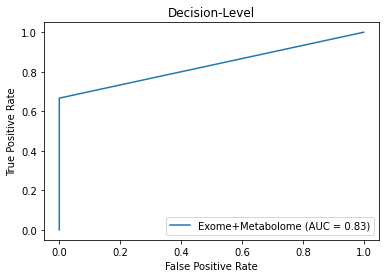

In [ ]:
# Stacking
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

#estimators = [('rf', rf_G_model.best_estimator_), ('mlp', mlp_G_model.best_estimator_), ('knn', knn_G_model.best_estimator_)]
#estimators = [('rf', rf_G_model.best_estimator_), ('mlp', mlp_G_model.best_estimator_), ('gnb', GaussianNB())]
#estimators = [('knn', knn_G_model.best_estimator_), ('rf_c', rf_C_smote_model.best_estimator_), ('rf_m', rf_M_model.best_estimator_)]
#estimators = [('knn', knn_G_model.best_estimator_), ('gnb', mnb.best_estimator_)]
estimators = [('knn', knn_G_model.best_estimator_), ('rf_m', rf_M_model.best_estimator_)]
#estimators = [('knn', knn_G_model.best_estimator_), ('Ada', clf.best_estimator_), ('rf_m', rf_M_model.best_estimator_)]

sc_LR = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
#sc_NB = StackingClassifier(estimators=estimators, final_estimator=GaussianNB(), verbose=1)

sc_LR_model = sc_LR.fit(X_train_C_sm, y_train_C_sm)
#sc_NB_model = sc_NB.fit(X_train_C_sm, y_train_C_sm)

y_LRpred = sc_LR_model.predict(X_test_C_sm)
#y_NBpred = sc_NB_model.predict(X_test_C_sm)

print("\n")
print("LR Results: ")
print("-----------------------------------------------------------------")
print(test_metrics(y_test_C_sm, y_LRpred))
print(y_LRpred)
print(y_test_C_sm)
#print("NB Results: ")
#print("-----------------------------------------------------------------")
#print(test_metrics(y_test_C_sm, y_NBpred))

fpr, tpr, thresholds = metrics.roc_curve(y_test_C_sm, y_LRpred, pos_label=2)
roc_auc = metrics.auc(fpr, tpr)
displayEM = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Exome+Metabolome')
displayEM.plot()
plt.title('Decision-Level')

#roc = RocCurveDisplay.from_estimator(sc_LR_model, X_test_C_sm, y_test_C_sm, name="Exome+Metabolite").figure_.suptitle("Exome+Metabolite ROC curve")
#roc = RocCurveDisplay.from_estimator(sc_NB_model, X_test_C_sm, y_test_C_sm, name="Exome-Metabolite").figure_.suptitle("Exome-Metabolite ROC curve")

# Phenotype addition ⚡💯⚡

In [ ]:
### Data level

genLabel = [310383, 310382, 310380, 310381, 310357, 310358, 310359, 310391, 310388, 
            310374, 310376, 310377, 310375, 310386, 310373, 310371, 310370, 310362, 
            310364, 310363, 310365, 310366, 310367, 310368]

metLabel = ["P001", "P005" ,"P011", "P016", "P024", "P029", "P034", "P044-1", "P049-1",
            "P054", "P059" ,"P064", "P069", "P078", "P084", "P090", "P093", "P099", "P104", 
            "P109", "P119", "P124", "P129", "P134"]

phenLabel = ["D057", "D055", "D056", "D059", "D025", "D026", "D024", "D086", "D083", "D050", 
             "D051", "D041", "D042", "D021", "D038", "D045", "D022", "D040", "D028", "D029",
             "D039", "D034", "D035", "D036"]

print(len(genLabel), len(metLabel), len(phenLabel))
#combo = pd.DataFrame(genLabel, metLabel, phenLabel)
combo_phen = pd.DataFrame()
combo_phen['genL'] = genLabel
#combo['genL'] = combo['genL'].astype(str)
combo_phen['metL'] = metLabel
combo_phen['phenL'] = list(map(str, phenLabel))

#print(combo['phenL'])
#print(phen['SUBID'])
#print(final.columns)

combo_phen = pd.merge(combo_phen, final, left_on=['genL'], right_index=True).drop('Affected', axis=1).drop('genL', axis=1)
combo_phen = pd.merge(combo_phen, met, left_on=['metL'], right_index=True).drop('metL', axis=1)
combo_phen = pd.merge(combo_phen, phen, left_on=['phenL'], right_on=['SUBID']).drop('phenL', axis=1).drop('Ever Affected', axis=1).drop('Aff., Unaff.', axis=1).drop('SUBID', axis=1).drop('FAMID', axis=1)
combo_phen_labels = combo_phen.loc[:,combo_phen.columns != 'Label']
combo_phen_labels.rename(columns={'RAN_NUM_SS': 'RAN NUM Score', 'papapa_z': 'papapa Score', 'WIDSSoffial': 'WID Score', 'WIAT_SPELL_SS': 'WIAT SPELL Score'}, inplace=True)

#print(combo_phen.columns.get_loc('Label'))
#print(combo_phen.shape)
#ombo.to_csv('/content/drive/My Drive/AI_Dyslexia_Diagnostics/combo_w_phenotype.csv')

X_combo_phen = combo_phen.loc[:,:]
print(X_combo_phen.shape)
X_combo_phen = X_combo_phen.loc[:,X_combo_phen.columns != 'Label']
print(X_combo_phen.shape)
y_combo_phen = combo_phen.iloc[:, 331]
print(y_combo_phen)
print(y_combo_phen[y_combo_phen == 1].shape)
#print(y_combo_phen)
#print(pd.isnull(X_combo_phen))

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_combo_phen = imp.fit_transform(X_combo_phen)

#print(pd.isnull(X_combo_phen))

# 80/20 t&v/test split
X_train_CP, X_test_CP, y_train_CP, y_test_CP = train_test_split(X_combo_phen, y_combo_phen, test_size=.2, stratify=y_combo_phen, random_state=33)

#print(y_test_C)

### SMOTE ###
smote = SMOTE(sampling_strategy='minority', random_state=18, k_neighbors=3)

X_combo_phen_sm, y_combo_phen_sm = smote.fit_resample(X_combo_phen, y_combo_phen)
print(X_combo_phen_sm.shape)
print(y_combo_phen_sm.shape)
print(y_combo_phen_sm[y_combo_phen_sm == 2].shape)

X_train_CP_sm, X_test_CP_sm, y_train_CP_sm, y_test_CP_sm = train_test_split(X_combo_phen_sm, y_combo_phen_sm, test_size=.2, random_state=33)

print(y_test_CP_sm)
#print(y_test_CP_sm)

24 24 24
(19, 648)
(19, 647)
0     2
1     1
2     2
3     2
4     1
5     2
6     2
7     2
8     2
9     2
10    1
11    2
12    1
13    2
14    2
15    2
16    2
17    2
18    2
Name: Label, dtype: int64
(4,)
(30, 647)
(30,)
(15,)
29    1
16    2
17    2
5     2
4     1
8     2
Name: Label, dtype: int64


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [ ]:
### STACKING ###
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV


rf_pipe = Pipeline(steps=[('rf', RandomForestClassifier(random_state=1))])
param_grid = {'rf__n_estimators': [3], 'rf__max_depth': [2,3,5] }
rf_P_model = GridSearchCV(rf_pipe, param_grid, cv=cv, scoring=scoringa, refit=metric_used, return_train_score=True, verbose=3)
rf_P_model = rf_P_model.fit(X_train_p, y_train_p)


print("Best estimator found by grid search:")
print(rf_P_model.best_estimator_)
# RESULT: Pipeline(steps=[('rf', RandomForestClassifier(max_depth=3, n_estimators=25))])
y_hat_RF_P = rf_P_model.predict(X_test_p)
print(test_metrics(y_test_p, y_hat_RF_P))

#cp = RocCurveDisplay.from_estimator(rf_P_model, X_test_p, y_test_p, name="Phenome RF")

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 1/10] END rf__max_depth=2, rf__n_estimators=3; accuracy: (train=0.976, test=1.000) f1_score: (train=0.973, test=1.000) kappa: (train=0.951, test=1.000) mcc: (train=0.952, test=1.000) precision: (train=0.947, test=1.000) precision-recall: (train=0.439, test=0.600) recall: (train=1.000, test=1.000) roc_auc: (train=0.978, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=0.957, test=1.000) total time=   0.0s
[CV 2/10] END rf__max_depth=2, rf__n_estimators=3; accuracy: (train=0.951, test=0.800) f1_score: (train=0.947, test=0.000) kappa: (train=0.902, test=0.000) mcc: (train=0.906, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.448, test=0.200) recall: (train=0.900, test=0.000) roc_auc: (train=0.950, test=0.500) sensitivity: (train=0.900, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV 3/10] END rf__max_depth=2, rf__n_estimators=3; accuracy: (train=0.976, test=0.800) f1_score: (train=0.973, test=0.857) kappa: (train=0.951, test=0.545) mcc: (train=0.952, test=0.612) precision: (train=0.947, test=0.750) precision-recall: (train=0.439, test=0.600) recall: (train=1.000, test=1.000) roc_auc: (train=0.978, test=0.750) sensitivity: (train=1.000, test=1.000) specificity: (train=0.957, test=0.500) total time=   0.1s
[CV 4/10] END rf__max_depth=2, rf__n_estimators=3; accuracy: (train=0.976, test=nan) f1_score: (train=0.970, test=nan) kappa: (train=0.949, test=nan) mcc: (train=0.951, test=nan) precision: (train=0.941, test=nan) precision-recall: (train=0.390, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=0.980, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=0.960, test=nan) total time=   0.0s
[CV 5/10] END rf__max_depth=2, rf__n_estimators=3; accuracy: (train=1.000, test=0.800) f1_score: (train=1.000, test=0.800) kappa: (train=1.000, test=0.6

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. Th

[CV 7/10] END rf__max_depth=2, rf__n_estimators=3; accuracy: (train=0.929, test=nan) f1_score: (train=0.923, test=nan) kappa: (train=0.857, test=nan) mcc: (train=0.866, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.446, test=nan) recall: (train=0.857, test=nan) roc_auc: (train=0.929, test=nan) sensitivity: (train=0.857, test=nan) specificity: (train=1.000, test=nan) total time=   0.0s
[CV 8/10] END rf__max_depth=2, rf__n_estimators=3; accuracy: (train=0.929, test=0.500) f1_score: (train=0.919, test=0.500) kappa: (train=0.855, test=0.000) mcc: (train=0.856, test=0.000) precision: (train=0.944, test=0.500) precision-recall: (train=0.414, test=0.500) recall: (train=0.895, test=0.500) roc_auc: (train=0.926, test=0.500) sensitivity: (train=0.895, test=0.500) specificity: (train=0.957, test=0.500) total time=   0.0s
[CV 9/10] END rf__max_depth=2, rf__n_estimators=3; accuracy: (train=0.976, test=0.750) f1_score: (train=0.976, test=0.667) kappa: (train=0.952, test=0.5

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV 6/10] END rf__max_depth=3, rf__n_estimators=3; accuracy: (train=0.951, test=1.000) f1_score: (train=0.944, test=1.000) kappa: (train=0.901, test=1.000) mcc: (train=0.906, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.423, test=0.400) recall: (train=0.895, test=1.000) roc_auc: (train=0.947, test=1.000) sensitivity: (train=0.895, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.0s
[CV 7/10] END rf__max_depth=3, rf__n_estimators=3; accuracy: (train=0.976, test=nan) f1_score: (train=0.976, test=nan) kappa: (train=0.952, test=nan) mcc: (train=0.953, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.478, test=nan) recall: (train=0.952, test=nan) roc_auc: (train=0.976, test=nan) sensitivity: (train=0.952, test=nan) specificity: (train=1.000, test=nan) total time=   0.0s
[CV 8/10] END rf__max_depth=3, rf__n_estimators=3; accuracy: (train=0.976, test=0.750) f1_score: (train=0.973, test=0.667) kappa: (train=0.952, test=0.5

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. Th

[CV 1/10] END rf__max_depth=5, rf__n_estimators=3; accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.439, test=0.600) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.0s
[CV 2/10] END rf__max_depth=5, rf__n_estimators=3; accuracy: (train=0.976, test=0.800) f1_score: (train=0.974, test=0.000) kappa: (train=0.951, test=0.000) mcc: (train=0.952, test=0.000) precision: (train=1.000, test=0.000) precision-recall: (train=0.466, test=0.200) recall: (train=0.950, test=0.000) roc_auc: (train=0.975, test=0.500) sensitivity: (train=0.950, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.0s
[CV 3/10] END rf__max_depth=5, rf__n_estimators=3; accuracy: (train=0.976, test=0.600) f1_score: (train=0.973, test=0.667) kappa: (t

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV 6/10] END rf__max_depth=5, rf__n_estimators=3; accuracy: (train=0.951, test=1.000) f1_score: (train=0.944, test=1.000) kappa: (train=0.901, test=1.000) mcc: (train=0.906, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.423, test=0.400) recall: (train=0.895, test=1.000) roc_auc: (train=0.947, test=1.000) sensitivity: (train=0.895, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.0s
[CV 7/10] END rf__max_depth=5, rf__n_estimators=3; accuracy: (train=0.976, test=nan) f1_score: (train=0.976, test=nan) kappa: (train=0.952, test=nan) mcc: (train=0.953, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.478, test=nan) recall: (train=0.952, test=nan) roc_auc: (train=0.976, test=nan) sensitivity: (train=0.952, test=nan) specificity: (train=1.000, test=nan) total time=   0.0s
[CV 8/10] END rf__max_depth=5, rf__n_estimators=3; accuracy: (train=0.976, test=0.750) f1_score: (train=0.973, test=0.667) kappa: (train=0.952, test=0.5

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. Th

Best estimator found by grid search:
Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, n_estimators=3,
                                        random_state=1))])
['acc: 0.7500' 'percision: 0.6667' 'recall: 0.5000' 'F1: 0.5714'
 ': 0.6875' '0.2778' '0.4082' '0.4000' '0.5000' '0.8750']


Text(0, 0.5, 'True Positive Rate (Positive label: 2)')

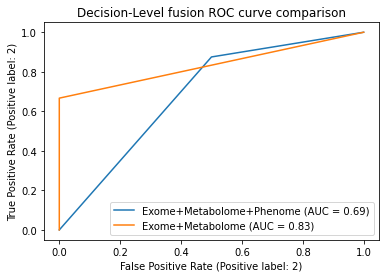

In [ ]:

fpr, tpr, thresholds = metrics.roc_curve(y_test_p, y_hat_RF_P, pos_label=2)
roc_auc = metrics.auc(fpr, tpr)
displayEMP = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Exome+Metabolome+Phenome')
displayEMP.plot()
displayEM.plot(ax=displayEMP.ax_)
plt.title('Decision-Level fusion ROC curve comparison')
plt.xlabel('False Positive Rate (Positive label: 2)')
plt.ylabel('True Positive Rate (Positive label: 2)')



LR Results: 
-----------------------------------------------------------------
['acc: 0.8333' 'percision: 0.6667' 'recall: 1.0000' 'F1: 0.8000'
 ': 0.8750' '0.3333' '0.7071' '0.6667' '1.0000' '0.7500']






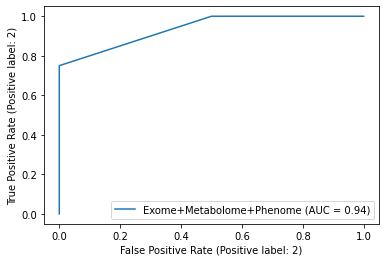

In [ ]:
# Stacking
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

#estimators = [('rf', rf_G_model.best_estimator_), ('mlp', mlp_G_model.best_estimator_), ('knn', knn_G_model.best_estimator_)]
#estimators = [('rf', rf_G_model.best_estimator_), ('mlp', mlp_G_model.best_estimator_), ('gnb', GaussianNB())]
#estimators = [('knn', knn_G_model.best_estimator_), ('rf_c', rf_C_smote_model.best_estimator_), ('rf_m', rf_M_model.best_estimator_), ('rf_p', rf_P_model.best_estimator_)]
estimators_p = [('knn', knn_G_model.best_estimator_), ('rf_m', rf_M_model.best_estimator_), ('knn_p', knn_P_model.best_estimator_)]

sc_P_LR = StackingClassifier(estimators=estimators_p, final_estimator=LogisticRegression())
#sc_P_NB = StackingClassifier(estimators=estimators_p, final_estimator=GaussianNB())

sc_P_LR_model = sc_P_LR.fit(X_train_CP_sm, y_train_CP_sm)
#sc_P_NB_model = sc_P_NB.fit(X_train_CP_sm, y_train_CP_sm)

y_P_LRpred = sc_P_LR_model.predict(X_test_CP_sm)
#y_P_NBpred = sc_P_NB_model.predict(X_test_CP_sm)

print("\n")
print("LR Results: ")
print("-----------------------------------------------------------------")
print(test_metrics(y_test_CP_sm, y_P_LRpred))
print("\n")
#print("NB Results: ")
#print("-----------------------------------------------------------------")
#rint(test_metrics(y_test_CP_sm, y_P_NBpred))


cp = RocCurveDisplay.from_estimator(sc_P_LR_model, X_test_CP_sm, y_test_CP_sm, name="Exome+Metabolome+Phenome")
print('\n')

#pheno = plot_roc_curve(rf_P_model, X_test_p, y_test_p, name="Phenotype RF", ax=knn_P.ax_)

#fpr, tpr, thresholds = metrics.roc_curve(y_test_CP_sm, y_P_LRpred, pos_label=2)
#roc_auc = metrics.auc(fpr, tpr)
#display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Exome+Metabolome+Phenome')
#display.plot()
#plt.title('Decision-Level')

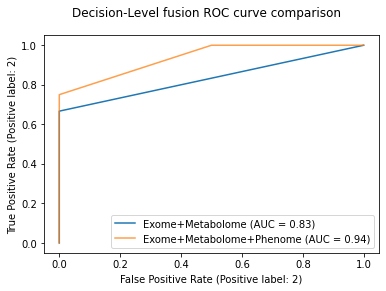

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_C_sm, y_LRpred, pos_label=2)
roc_auc = metrics.auc(fpr, tpr)
displayEM = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Exome+Metabolome')
displayEM.plot()

cp = RocCurveDisplay.from_estimator(sc_P_LR_model, X_test_CP_sm, y_test_CP_sm, name="Exome+Metabolome+Phenome", ax=displayEM.ax_, alpha=0.75).figure_.suptitle("Decision-Level fusion ROC curve comparison")

#cp = plot_roc_curve(sc_LR_model, X_test_C_sm, y_test_C_sm, name="Exome+Metabolome", ax=displayEM.ax_, alpha=0.75).figure_.suptitle("Decision-Level fusion ROC curve comparison")

In [ ]:
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

param_grid = {'base_estimator__max_depth':[3,5],
              'base_estimator__min_samples_leaf':[3,6],
              'n_estimators':[7,15],
              'learning_rate':[0.001]}

clf = GridSearchCV(abc, param_grid, cv=cv, scoring=scoringa, refit=metric_used, return_train_score=True, verbose=2)
ada_CP = clf.fit(X_train_CP_sm, y_train_CP_sm)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. Th

[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=3, learning_ra

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. Th

[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=6, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=6, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=6, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=6, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=6, learning_rate

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. Th

[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=6, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=6, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=6, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=6, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=6, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=6, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=6, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=6, learning_rat

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. Th

[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=6, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=6, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=6, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=6, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=3, learning_rat

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. Th

[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=3, learning_rate=

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. Th

[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=3, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=6, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=6, learning_r

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. Th

[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=6, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=6, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=6, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=6, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=6, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=6, learning_rate=0.001, n_estimators=7; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=6, learning_rate=0.001, n_estimators=15; total time=   0.0s
[CV] END base_estimator__max_depth=5, base_estimator__min_samples_leaf=6, learning_rate=0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. Th

In [ ]:
print(ada_CP.best_estimator_)
y_P = ada_CP.predict(X_test_CP_sm)
print(test_metrics(y_test_CP_sm, y_P))

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         min_samples_leaf=3),
                   learning_rate=0.001, n_estimators=7)
['acc: 0.8333' 'percision: 0.6667' 'recall: 1.0000' 'F1: 0.8000'
 ': 0.8750' '0.3333' '0.7071' '0.6667' '1.0000' '0.7500']


['acc: 0.8333' 'percision: 1.0000' 'recall: 0.5000' 'F1: 0.6667'
 ': 0.7500' '0.2667' '0.6325' '0.5714' '0.5000' '1.0000']
[[1 1]
 [0 4]]


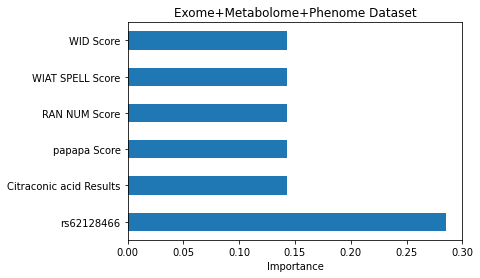

In [ ]:
from numpy.random import seed
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
ada_model_CP = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4, min_samples_leaf=4), 
                                  learning_rate=0.001, n_estimators=7, random_state=1)
ada_model_CP = ada_model_CP.fit(X_train_CP, y_train_CP)

yee = ada_model_CP.predict(X_test_CP_sm)
print(test_metrics(y_test_CP_sm, yee))

# confusion_matrix(y_true, y_pred)
print(confusion_matrix(y_test_CP_sm, yee))
#print(ada_model.feature_importances_)
#print(X_combo)
feat_importances_CP = pd.Series(ada_model_CP.feature_importances_, index=combo_phen_labels.columns)
feat_importances_CP.nlargest(6).plot(kind='barh')
plt.xlabel('Importance')
plt.title('Exome+Metabolome+Phenome Dataset')
plt.show()

#roc = RocCurveDisplay.from_estimator(ada_model_CP, X_test_CP, y_test_CP, name="Exome+Metabolome+Clinical ADA", pos_label=2)

In [ ]:
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV


nn_pipe = Pipeline(steps=[('mlp', MLPClassifier())])
param_grid2 = {'mlp__hidden_layer_sizes': [(10, 25, 10), (500, 50, 5)], 'mlp__alpha':[.0005, .001]}

mlp = GridSearchCV(nn_pipe, param_grid2, cv=cv, scoring=scoringa, refit=metric_used, return_train_score=True, verbose=3)
mlp_CP_smote_model = mlp.fit(X_train_CP_sm, y_train_CP_sm)

print("Best estimator found by grid search:")
print("----------------------------------------")
print("----------------------------------------")
print("----------------------------------------")
print(mlp_CP_smote_model.best_estimator_)
# RESULT: Pipeline(steps=[('mlp', MLPClassifier(hidden_layer_sizes=(10, 10, 10)))])

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV 1/10] END mlp__alpha=0.0005, mlp__hidden_layer_sizes=(10, 25, 10); accuracy: (train=0.476, test=0.000) f1_score: (train=0.154, test=0.000) kappa: (train=-0.085, test=-0.800) mcc: (train=-0.117, test=-1.000) precision: (train=0.333, test=0.000) precision-recall: (train=0.498, test=1.000) recall: (train=0.100, test=0.000) roc_auc: (train=0.459, test=0.000) sensitivity: (train=0.100, test=0.000) specificity: (train=0.818, test=0.000) total time=   0.0s
[CV 2/10] END mlp__alpha=0.0005, mlp__hidden_layer_sizes=(10, 25, 10); accuracy: (train=0.381, test=0.333) f1_score: (train=0.000, test=0.000) kappa: (train=-0.358, test=0.000) mcc: (train=-0.420, test=0.000) precision: (train=0.000, test=0.000) precision-recall: (train=0.529, test=0.667) recall: (train=0.000, test=0.000) roc_auc: (train=0.333, test=0.500) sensitivity: (train=0.000, test=0.000) specificity: (train=0.667, test=1.000) total time=   0.0s
[CV 3/10] END mlp__alpha=

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/pytho

[CV 5/10] END mlp__alpha=0.0005, mlp__hidden_layer_sizes=(10, 25, 10); accuracy: (train=0.909, test=0.500) f1_score: (train=0.909, test=0.000) kappa: (train=0.820, test=0.000) mcc: (train=0.833, test=0.000) precision: (train=0.833, test=0.000) precision-recall: (train=0.455, test=0.500) recall: (train=1.000, test=0.000) roc_auc: (train=0.917, test=0.500) sensitivity: (train=1.000, test=0.000) specificity: (train=0.833, test=1.000) total time=   0.1s
[CV 6/10] END mlp__alpha=0.0005, mlp__hidden_layer_sizes=(10, 25, 10); accuracy: (train=0.955, test=0.500) f1_score: (train=0.952, test=0.667) kappa: (train=0.909, test=0.000) mcc: (train=0.913, test=0.000) precision: (train=0.909, test=0.500) precision-recall: (train=0.455, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=0.958, test=0.500) sensitivity: (train=1.000, test=1.000) specificity: (train=0.917, test=0.000) total time=   0.1s
[CV 7/10] END mlp__alpha=0.0005, mlp__hidden_layer_sizes=(10, 25, 10); accuracy: (train=0.86

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. Th

[CV 9/10] END mlp__alpha=0.0005, mlp__hidden_layer_sizes=(10, 25, 10); accuracy: (train=0.364, test=0.500) f1_score: (train=0.000, test=0.000) kappa: (train=-0.351, test=0.000) mcc: (train=-0.430, test=0.000) precision: (train=0.000, test=0.000) precision-recall: (train=0.556, test=0.500) recall: (train=0.000, test=0.000) roc_auc: (train=0.333, test=0.500) sensitivity: (train=0.000, test=0.000) specificity: (train=0.667, test=1.000) total time=   0.0s
[CV 10/10] END mlp__alpha=0.0005, mlp__hidden_layer_sizes=(10, 25, 10); accuracy: (train=0.500, test=nan) f1_score: (train=0.667, test=nan) kappa: (train=0.000, test=nan) mcc: (train=0.000, test=nan) precision: (train=0.500, test=nan) precision-recall: (train=0.500, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=0.500, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=0.000, test=nan) total time=   0.0s
[CV 1/10] END mlp__alpha=0.0005, mlp__hidden_layer_sizes=(500, 50, 5); accuracy: (train=0.476, test=0.333) f1

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV 2/10] END mlp__alpha=0.0005, mlp__hidden_layer_sizes=(500, 50, 5); accuracy: (train=0.429, test=0.667) f1_score: (train=0.600, test=0.800) kappa: (train=0.000, test=0.000) mcc: (train=0.000, test=0.000) precision: (train=0.429, test=0.667) precision-recall: (train=0.429, test=0.667) recall: (train=1.000, test=1.000) roc_auc: (train=0.500, test=0.500) sensitivity: (train=1.000, test=1.000) specificity: (train=0.000, test=0.000) total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV 3/10] END mlp__alpha=0.0005, mlp__hidden_layer_sizes=(500, 50, 5); accuracy: (train=0.619, test=nan) f1_score: (train=0.000, test=nan) kappa: (train=0.000, test=nan) mcc: (train=0.000, test=nan) precision: (train=0.000, test=nan) precision-recall: (train=0.381, test=nan) recall: (train=0.000, test=nan) roc_auc: (train=0.500, test=nan) sensitivity: (train=0.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/10] END mlp__alpha=0.0005, mlp__hidden_layer_sizes=(500, 50, 5); accuracy: (train=0.524, test=0.667) f1_score: (train=0.000, test=0.000) kappa: (train=0.000, test=0.000) mcc: (train=0.000, test=0.000) precision: (train=0.000, test=0.000) precision-recall: (train=0.476, test=0.333) recall: (train=0.000, test=0.000) roc_auc: (train=0.500, test=0.500) sensitivity: (train=0.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/10] END mlp__alpha=0.0005, mlp__hidden_layer_sizes=(500, 50, 5); accuracy: (train=0.545, test=0.500) f1_score: (train=0.000, test=0.000) kappa: (train=0.000, test=0.000) mcc: (train=0.000, test=0.000) precision: (train=0.000, test=0.000) precision-recall: (train=0.455, test=0.500) recall: (train=0.000, test=0.000) roc_auc: (train=0.500, test=0.500) sensitivity: (train=0.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.3s
[CV 6/10] END mlp__alpha=0.0005, mlp__hidden_layer_sizes=(500, 50, 5); accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.455, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.6s
[CV 7/10] END mlp__alpha=0.0005, mlp__hidden_layer_sizes=(500, 50, 5); accuracy: (train=0.45

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV 8/10] END mlp__alpha=0.0005, mlp__hidden_layer_sizes=(500, 50, 5); accuracy: (train=0.727, test=nan) f1_score: (train=0.786, test=nan) kappa: (train=0.455, test=nan) mcc: (train=0.542, test=nan) precision: (train=0.647, test=nan) precision-recall: (train=0.500, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=0.727, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=0.455, test=nan) total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 9/10] END mlp__alpha=0.0005, mlp__hidden_layer_sizes=(500, 50, 5); accuracy: (train=0.545, test=0.500) f1_score: (train=0.000, test=0.000) kappa: (train=0.000, test=0.000) mcc: (train=0.000, test=0.000) precision: (train=0.000, test=0.000) precision-recall: (train=0.455, test=0.500) recall: (train=0.000, test=0.000) roc_auc: (train=0.500, test=0.500) sensitivity: (train=0.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. Th

[CV 10/10] END mlp__alpha=0.0005, mlp__hidden_layer_sizes=(500, 50, 5); accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.500, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.7s
[CV 1/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 25, 10); accuracy: (train=0.524, test=0.667) f1_score: (train=0.444, test=0.000) kappa: (train=0.037, test=0.000) mcc: (train=0.037, test=0.000) precision: (train=0.500, test=0.000) precision-recall: (train=0.467, test=0.333) recall: (train=0.400, test=0.000) roc_auc: (train=0.518, test=0.500) sensitivity: (train=0.400, test=0.000) specificity: (train=0.636, test=1.000) total time=   0.1s
[CV 2/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 25, 10); accuracy: (train=1.000, test=0.667) f1_sco

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py", line 572, in roc_auc_score
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_base.py", line 75, in _average_binary_score
    return binary_metric(y_tr

[CV 3/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 25, 10); accuracy: (train=0.571, test=nan) f1_score: (train=0.471, test=nan) kappa: (train=0.113, test=nan) mcc: (train=0.113, test=nan) precision: (train=0.444, test=nan) precision-recall: (train=0.357, test=nan) recall: (train=0.500, test=nan) roc_auc: (train=0.558, test=nan) sensitivity: (train=0.500, test=nan) specificity: (train=0.615, test=nan) total time=   0.0s
[CV 4/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 25, 10); accuracy: (train=1.000, test=1.000) f1_score: (train=1.000, test=1.000) kappa: (train=1.000, test=1.000) mcc: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.476, test=0.333) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) sensitivity: (train=1.000, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.0s
[CV 5/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(10, 25, 10); accuracy: (train=0.455, test=0.000) f1_score

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

[CV 1/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(500, 50, 5); accuracy: (train=0.619, test=1.000) f1_score: (train=0.333, test=1.000) kappa: (train=0.208, test=1.000) mcc: (train=0.340, test=1.000) precision: (train=1.000, test=1.000) precision-recall: (train=0.432, test=0.333) recall: (train=0.200, test=1.000) roc_auc: (train=0.600, test=1.000) sensitivity: (train=0.200, test=1.000) specificity: (train=1.000, test=1.000) total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(500, 50, 5); accuracy: (train=0.571, test=0.333) f1_score: (train=0.000, test=0.000) kappa: (train=0.000, test=0.000) mcc: (train=0.000, test=0.000) precision: (train=0.000, test=0.000) precision-recall: (train=0.429, test=0.667) recall: (train=0.000, test=0.000) roc_auc: (train=0.500, test=0.500) sensitivity: (train=0.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, 

[CV 3/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(500, 50, 5); accuracy: (train=0.619, test=nan) f1_score: (train=0.000, test=nan) kappa: (train=0.000, test=nan) mcc: (train=0.000, test=nan) precision: (train=0.000, test=nan) precision-recall: (train=0.381, test=nan) recall: (train=0.000, test=nan) roc_auc: (train=0.500, test=nan) sensitivity: (train=0.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(500, 50, 5); accuracy: (train=0.524, test=0.667) f1_score: (train=0.000, test=0.000) kappa: (train=0.000, test=0.000) mcc: (train=0.000, test=0.000) precision: (train=0.000, test=0.000) precision-recall: (train=0.476, test=0.333) recall: (train=0.000, test=0.000) roc_auc: (train=0.500, test=0.500) sensitivity: (train=0.000, test=0.000) specificity: (train=1.000, test=1.000) total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(500, 50, 5); accuracy: (train=0.455, test=0.500) f1_score: (train=0.625, test=0.667) kappa: (train=0.000, test=0.000) mcc: (train=0.000, test=0.000) precision: (train=0.455, test=0.500) precision-recall: (train=0.455, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=0.500, test=0.500) sensitivity: (train=1.000, test=1.000) specificity: (train=0.000, test=0.000) total time=   4.4s
[CV 6/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(500, 50, 5); accuracy: (train=0.455, test=0.500) f1_score: (train=0.625, test=0.667) kappa: (train=0.000, test=0.000) mcc: (train=0.000, test=0.000) precision: (train=0.455, test=0.500) precision-recall: (train=0.455, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=0.500, test=0.500) sensitivity: (train=1.000, test=1.000) specificity: (train=0.000, test=0.000) total time=   1.2s
[CV 7/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(500, 50, 5); accuracy: (train=0.455, 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. Th

[CV 8/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(500, 50, 5); accuracy: (train=1.000, test=nan) f1_score: (train=1.000, test=nan) kappa: (train=1.000, test=nan) mcc: (train=1.000, test=nan) precision: (train=1.000, test=nan) precision-recall: (train=0.500, test=nan) recall: (train=1.000, test=nan) roc_auc: (train=1.000, test=nan) sensitivity: (train=1.000, test=nan) specificity: (train=1.000, test=nan) total time=   0.8s
[CV 9/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(500, 50, 5); accuracy: (train=0.455, test=0.500) f1_score: (train=0.625, test=0.667) kappa: (train=0.000, test=0.000) mcc: (train=0.000, test=0.000) precision: (train=0.455, test=0.500) precision-recall: (train=0.455, test=0.500) recall: (train=1.000, test=1.000) roc_auc: (train=0.500, test=0.500) sensitivity: (train=1.000, test=1.000) specificity: (train=0.000, test=0.000) total time=   0.3s
[CV 10/10] END mlp__alpha=0.001, mlp__hidden_layer_sizes=(500, 50, 5); accuracy: (train=1.000, test=nan) f1_score:

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. Th

In [ ]:
y_CP = mlp_CP_smote_model.predict(X_test_CP_sm)
print(test_metrics(y_test_CP_sm, y_CP))

['acc: 0.6667' 'percision: 0.5000' 'recall: 1.0000' 'F1: 0.6667'
 ': 0.7500' '0.3333' '0.5000' '0.4000' '1.0000' '0.5000']


In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline, make_pipeline

knn_pipe = Pipeline(steps=[('knn', KNeighborsClassifier())])
param_grid = {'knn__n_neighbors': [3, 5]}
knn = GridSearchCV(knn_pipe, param_grid, cv=cv, scoring=scoringa, refit=metric_used, return_train_score=True, verbose=0)
knn_CP_model = knn.fit(X_train_CP_sm, y_train_CP_sm)

print("Best estimator found by grid search:")
print(knn_CP_model.best_estimator_)
# RESULT: Pipeline(steps=[('knn', KNeighborsClassifier(n_neighbors=1))])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._

Best estimator found by grid search:
Pipeline(steps=[('knn', KNeighborsClassifier(n_neighbors=3))])


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py", line 572, in roc_auc_score
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_base.py", line 75, in _average_binary_score
    return binary_metric(y_tr

In [ ]:
y_CP_KNN =knn_CP_model.predict(X_test_CP_sm)
print(test_metrics(y_test_CP_sm, y_CP_KNN))

['acc: 0.8333' 'percision: 0.8000' 'recall: 1.0000' 'F1: 0.8889'
 'ROC_AUC: 0.7500' '0.6667' '0.6325' '0.5714' '1.0000' '0.5000']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


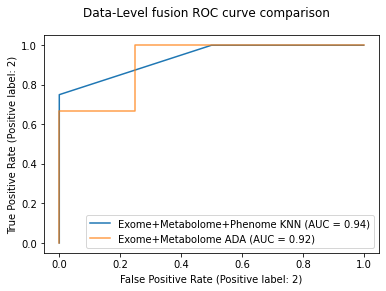

In [ ]:
cp_k = RocCurveDisplay.from_estimator(knn_CP_model, X_test_CP_sm, y_test_CP_sm, name="Exome+Metabolome+Phenome KNN")

cp_k = plot_roc_curve(ada_model, X_test_C_sm, y_test_C_sm, name="Exome+Metabolome ADA", ax=cp_k.ax_, alpha=0.75).figure_.suptitle("Data-Level fusion ROC curve comparison")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


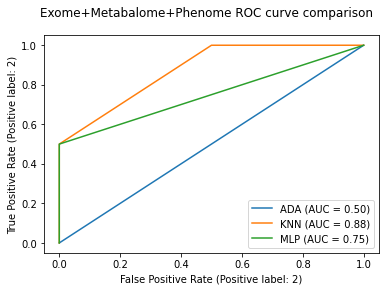

In [ ]:
cp_k = RocCurveDisplay.from_estimator(ada_CP, X_test_CP_sm, y_test_CP_sm, name="ADA")

cp_k = plot_roc_curve(knn_CP_model, X_test_CP_sm, y_test_CP_sm, name="KNN", ax=cp_k.ax_)

cp_k = plot_roc_curve(mlp_CP_smote_model, X_test_CP_sm, y_test_CP_sm, name="MLP", ax=cp_k.ax_).figure_.suptitle("Exome+Metabalome+Phenome ROC curve comparison")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. U

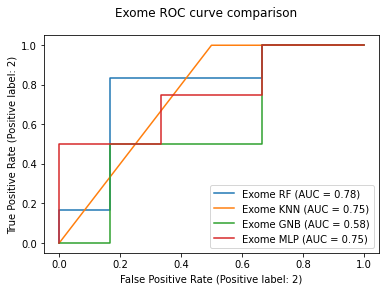

In [ ]:
# ROC
rf_G = RocCurveDisplay.from_estimator(rf_G_model, X_test_G_sm, y_test_G_sm, name="Exome RF")


knn_rf = plot_roc_curve(knn_G_model, X_test_G, y_test_G, name="Exome KNN", ax=rf_G.ax_)


exome = plot_roc_curve(mnb, X_test_G, y_test_G, name="Exome GNB", ax=knn_rf.ax_)


exome = plot_roc_curve(mlp_G_model, X_test_G, y_test_G, name="Exome MLP", ax=exome.ax_).figure_.suptitle("Exome ROC curve comparison")

In [ ]:

rf_M = RocCurveDisplay.from_estimator(rf_M_model, X_test_M_m, y_test_M_sm, name="Metabolite MLP")

metabolite = plot_roc_curve(mlp_M_model, X_test_M_sm, y_test_M_sm, name="Metabolite RF", ax=rf_M.ax_)

metabolite = plot_roc_curve(knn_M_model, X_test_M, y_test_M, name="Metabolite KNN", ax= metabolite.ax_)

metabolite = plot_roc_curve(knn_M_model, X_test_M, y_test_M, name="Metabolite GNB", ax= metabolite.ax_).figure_.suptitle("Metabolite ROC curve comparison")

NameError: ignored

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


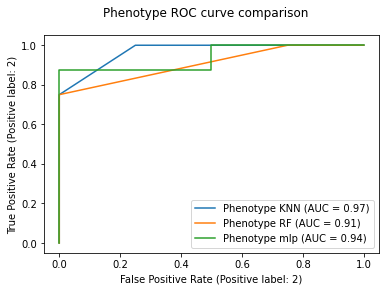

In [ ]:

knn_P = RocCurveDisplay.from_estimator(knn_P_model, X_test_p, y_test_p, name="Phenotype KNN")

pheno = plot_roc_curve(rf_P_model, X_test_p, y_test_p, name="Phenotype RF", ax=knn_P.ax_)

pheno = plot_roc_curve(mlp_P_model, X_test_p, y_test_p, name="Phenotype mlp", ax= pheno.ax_).figure_.suptitle("Phenotype ROC curve comparison")